In [25]:
%matplotlib inline
import matplotlib
import numpy as np

import datetime
import pandas as pd
# import talib
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from collections import defaultdict
import itertools

import pyfolio as pf
import empyrical as emp

import scipy
from scipy.stats import norm 

from math import sqrt, exp, log

#import QuantLib as ql

import statsmodels.api as sm
import itertools
import time

import statsmodels.api as sm
#from swifter import swiftapply

In [26]:
!conda info --envs

# conda environments:
#
base                     /Users/justinlent/ana32/anaconda3
                         /Users/justinlent/anaconda_2019_10/anaconda3
                      *  /Users/justinlent/anaconda_2019_10/anaconda3/envs/quant
                         /Users/justinlent/python/anaconda210/anaconda/envs/backup_07_14_2015
                         /Users/justinlent/python/anaconda210/anaconda/envs/quant
                         /Users/justinlent/python/anaconda210/anaconda/envs/quant_BACKUP_10_15_2015
                         /Users/justinlent/python/anaconda210/anaconda/envs/quant_pd17
                         /Users/justinlent/python/anaconda210/anaconda/envs/quant_sigopt_vegas
                         /Users/justinlent/python/anaconda240/anaconda/envs/py2_7_11_fresh
                         /Users/justinlent/python/anaconda240/anaconda/envs/quant
                         /Users/justinlent/python/anaconda240/anaconda/envs/root_BACKUP_original_install
                         /User

In [27]:
!git branch

* master


In [28]:
!pwd

/Users/justinlent/github_projects/algo_sandbox/option_simmer


# START OPTIMIZER CONFIG ######################

In [29]:
#########################################################################
#########################################################################

# TO-DO in the CSV file preparation:
# 1) convert Impl Vol columns from % string to Number in Excel
# 2) Make sure no NA or <empty> or -- strings are in columns

quotes_curr = pd.read_csv('SPY_option_quotes_2018_05_03_spot_262_62.csv', index_col=['Strike'])
#quotes_curr = pd.read_csv('2018-06-19-StockAndOptionQuoteForSPY_VIX_14_07_SPY_274_56.csv', index_col=['Strike'])
quotes_curr.head()

,Delta_C,Vega_C,Impl_Vol_C,Open_Int_C,BID_C,ASK_C,Exp,BID_P,ASK_P,Delta_P,Vega_P,Impl_Vol_P,Open_Int_P
Strike,,,,,,,,,,,,,
65,0.846,0.070,4.4688,575,197.95,198.23,15-Jun-18,0.0,0.01,0.0,0.001,1.1912,45
70,0.846,0.075,4.0491,200,192.96,193.24,15-Jun-18,0.0,0.01,0.0,0.001,1.1292,"2,215"
75,0.847,0.080,3.6857,450,187.97,188.25,15-Jun-18,0.0,0.01,0.0,0.001,1.0716,106
80,0.849,0.084,3.3693,300,182.99,183.27,15-Jun-18,0.0,0.01,0.0,0.001,1.0177,146
85,0.851,0.088,3.0892,30,178.00,178.28,15-Jun-18,0.0,0.01,0.0,0.001,0.9672,211


In [30]:
vix_current = 0.1407
market_current = 274.56

portfolio_notional = 100000

Rf = 0.0
div = 0.02

current_date = '2018-6-19'
date_to_reprice = '2018-7-16'
exp_date = '2018-7-20'

In [31]:
iv_atm_absolute_min = 0.08
iv_simulated_absolute_min = 0.06

vix_mkt_beta = {}
vix_mkt_beta[7] = (12, 9, 4)
vix_mkt_beta[14] = (9, 6, 14)
vix_mkt_beta[30] = (4.49, 6, 4, 9, 11.99, 15.99)

vix_mkt_beta_for_sim = vix_mkt_beta[30]

max_dd_desired = 0.15

#########################################################################
#########################################################################

# END OPTIMIZER CONFIG

In [32]:
calendar_days_ahead_to_reprice = (pd.to_datetime(date_to_reprice) - pd.to_datetime(current_date)).days
mkt_implied_1sigma_move = (vix_current/sqrt(365.25/calendar_days_ahead_to_reprice))

In [33]:
class Option(object):

    def __init__(self, c_or_p, strike, initial_imp_vol, exp_date, num_contracts, Rf, div, initial_underlying_px):

        self.c_or_p = c_or_p
        self.strike = strike
        self.initial_imp_vol = initial_imp_vol
        self.exp_date = pd.to_datetime(exp_date)
        self.num_contracts = num_contracts
        self.Rf = Rf
        self.div = div
        self.initial_underlying_px = initial_underlying_px
        
        
class VolatilitySurface(object):
    
    def __init__(self, type='linear', feature_def=None):
        
        pass

In [34]:
def calc_iv(option_price, call_put, S, K, T, r):
    n = norm.pdf
    N = norm.cdf

    def bs_price(cp_flag,S,K,T,r,v,q=0.0):
        d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
        d2 = d1-v*sqrt(T)
        if cp_flag == 'c':
            price = S*exp(-q*T)*N(d1)-K*exp(-r*T)*N(d2)
        else:
            price = K*exp(-r*T)*N(-d2)-S*exp(-q*T)*N(-d1)
        return price

    def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
        d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
        return S * sqrt(T)*n(d1)
    
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = option_price - price  # our root

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma


In [35]:
"""
# The Black Scholes Formula
# c_or_p : 'c' for call option
# K : strike
# T : time to maturity in years
# r : risk-free interest rate
# d : dividend yield
# v : implied volatility
"""

def bsm(c_or_p, S, K, T, r, d, v):
    #print( S, K, r, d, T, v)
    d1 = (log(float(S)/K) + ((r-d)+v*v/2.)*T) / (v*sqrt(T))
    d2 = d1 - v*sqrt(T)
    
    if c_or_p=='c':
        return S*exp(-d*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2) 
    else:
        return K*exp(-r*T)*norm.cdf(-d2) - S*exp(-d*T)*norm.cdf(-d1)
    
def bsm_greeks(c_or_p, S, K, T, r, d, v, approx_days_to_hold=7):
    g = OrderedDict()
    
    T_sqrt = sqrt(T)
    d1 = (log(float(S)/K) + ((r-d)+v*v/2.)*T) / (v*T_sqrt)
    d2 = d1-v*T_sqrt

    if c_or_p=='c':
        g['delta'] = norm.cdf(d1)
        g['rho'] = K * T * exp(-r*T) * norm.cdf(d2) / 100.
    else:
        g['delta'] = -norm.cdf(-d1)
        g['rho'] = -K * T * exp(-r*T) * norm.cdf(-d2) / 100.
        
    g['gamma'] = norm.pdf(d1) / (S*v*T_sqrt)
    g['vega'] = S * T_sqrt * norm.pdf(d1) / 100.
    g['theta'] =  bsm(c_or_p=c_or_p, S=S, K=K, T=T, r=r, d=d, v=v) - bsm(c_or_p=c_or_p, S=S, K=K, T=T-(1./365.25), r=r, d=d, v=v)
    g['theta'] =  g['theta'] * -1.

    g['theta_approx_over_holding_period'] =  bsm(c_or_p=c_or_p, S=S, K=K, T=T, r=r, d=d, v=v) - bsm(c_or_p=c_or_p, S=S, K=K, T=T-(approx_days_to_hold/365.25), r=r, d=d, v=v)
    g['theta_approx_over_holding_period'] =  ( g['theta_approx_over_holding_period'] / approx_days_to_hold ) * -1.

    return g

In [36]:
def reprice_iv_with_skew(option, iv_atm_curr, underlying_px_curr, underlying_px_orig, 
                         skew_model_params=None, skew_model='simple', interpolation='linear'):

    if skew_model=='simple':

        if interpolation=='linear':
            if skew_model_params is None:
                skew_model_params = {}
                
                skew_model_params['iv_atm_curr'] = vix_current                          # for SP500 options this can just be the VIX
                skew_model_params['iv_when_skew_flat'] = 0.50                           # assume skew is completely flat if VIX > 40
                skew_model_params['iv_when_skew_steepest'] = 0.12                       # assume skew is completely flat if VIX > 40
                skew_model_params['iv_steepness_maximum'] = 3.0                         # how to scale the ATM IV for skew based on that ATM IV amount
                
                skew_model_params['iv_absolute_min'] = 0.08                             # the absolute minimum value for IV

                skew_model_params['iv_strike_above_spot_scaling_minimum'] = 0.80                      # how to scale the ATM IV for an strikes way above spot
                skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness'] = 1.10     # the % of the strike versus spot when the scaling_minimum is applied for skew

                skew_model_params['iv_strike_below_spot_scaling_maximum'] = 3.0                       # how to scale the ATM IV for a strike way below spot
                skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness'] = 0.70     # the % of the strike versus spot when the scaling_maximum is applied for skew

                #skew_model_params['underlying_px_curr'] = mkt_px_curr
                #skew_model_params['underlying_px_orig'] = mkt_px_curr

            mkt_move_pct = underlying_px_curr / underlying_px_orig - 1.0
            iv_orig = option.initial_imp_vol
            K_vs_mkt = option.strike / underlying_px_curr

            iv_skew_scaling = 1.0
       
            iv_skew_scaling_steepness_factor = None
            
            if K_vs_mkt < 1.0:   # because of put-call parity this can also be used for both ITM Call & OTM Put implied vol
                iv_steepness_range = np.linspace(skew_model_params['iv_when_skew_steepest'], skew_model_params['iv_when_skew_flat'], 100)
                iv_skew_scaling_range = np.linspace(1.0, 1.0/skew_model_params['iv_steepness_maximum'], 100)

                if iv_atm_curr > skew_model_params['iv_when_skew_flat']:
                    iv_skew_scaling_steepness_factor = 1.0/skew_model_params['iv_steepness_maximum']
                else:
                    iv_skew_scaling_steepness_factor = iv_skew_scaling_range[ np.searchsorted(iv_steepness_range, iv_atm_curr) ]

                if K_vs_mkt < skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness']:
                    iv_skew_scaling = skew_model_params['iv_strike_below_spot_scaling_maximum'] * iv_skew_scaling_steepness_factor

                else:
                    K_vs_mkt_range = np.linspace(skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness'], 1.0, 100)
                    iv_skew_scaling_range = np.linspace(skew_model_params['iv_strike_below_spot_scaling_maximum'] * iv_skew_scaling_steepness_factor, 1.0, 100)
                    iv_skew_scaling = iv_skew_scaling_range[ np.searchsorted(K_vs_mkt_range, K_vs_mkt) ]


            if K_vs_mkt > 1.0:   # because of put-call parity this can also be used for OTM Call & ITM Put implied vol
                if K_vs_mkt > skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness']:
                    iv_skew_scaling = skew_model_params['iv_strike_above_spot_scaling_minimum']
                else:                            
                    K_vs_mkt_range = np.linspace(1.0, skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness'], 100)
                    iv_skew_scaling_range = np.linspace(1.0, skew_model_params['iv_strike_above_spot_scaling_minimum'], 100)
                    iv_skew_scaling = iv_skew_scaling_range[ np.searchsorted(K_vs_mkt_range, K_vs_mkt) ]

    
    repriced_iv = iv_skew_scaling * iv_atm_curr 
    
#    print(option.c_or_p, "iv_atm:", iv_atm_curr, "repriced_iv:", repriced_iv, "mkt_move_pct:", mkt_move_pct, "K:", option.strike, "Mkt:", underlying_px_curr, "K_vs_mkt:", K_vs_mkt, "updated skew scaling:", iv_skew_scaling, '\n')
    
    return repriced_iv


In [37]:
def approximate_term_struct_range_from_iv(iv_atm_curr, ts_range_step_width=0.05, ts_range_amount_from_mid=0.15, term_struct_model_params=None, term_struct_model='simple', interpolation='linear'):

    if skew_model=='simple':

        if interpolation=='linear':
            if term_struct_model_params is None:
                term_struct_model_params = {}
                
                skew_model_params['iv_atm_curr'] = vix_current                          # for SP500 options this can just be the VIX
                skew_model_params['iv_when_ts_flat'] =  0.12                            # flat means when ts scale is 1.0                          
                skew_model_params['iv_when_ts_most_inverted'] = 0.09                       
                skew_model_params['iv_when_ts_steepest'] = 0.50                       
                skew_model_params['scale_ts_minimum'] = 0.5                            # the absolute most scaled DOWN imp vol can be. e.g. if imp vol is 20% and scale_ts_minimum=0.5 would return 10% after the scaling
                skew_model_params['scale_ts_maximum'] = 1.33                           # the absolute most scaled UP imp vol can be. e.g. if imp vol is 20% and scale_ts_maximum=1.33 would return 26.6% after the scaling
                
                skew_model_params['iv_absolute_min'] = 0.08                            # the absolute minimum value for IV after applying the term structure approximation

    range_min =  skew_model_params['scale_ts_minimum']
    range_max =  skew_model_params['scale_ts_maximum']
    range_mid = (range_min + range_max) / 2.
    
    return list( np.arange( range_mid-ts_range_amount_from_mid, range_mid+ts_range_amount_from_mid, ts_range_step_width) )


In [38]:
def calc_portfolio_greeks(port, calc_initial_greeks=False, current_date=None, current_mkt_price=None):
    
    individual_port_greeks = {}
    portfolio_level_greeks = {}
    
    for option in port.keys():
        
        if calc_initial_greeks:
            days_to_exp_at_repricing = ( port[option].exp_date - pd.to_datetime(current_date) ).days
            individual_port_greeks[option] = bsm_greeks(c_or_p=port[option].c_or_p, S=port[option].initial_underlying_px, K=port[option].strike, T=days_to_exp_at_repricing/365.25, r=port[option].Rf, d=port[option].div, v=port[option].initial_imp_vol, approx_days_to_hold=30)
            individual_port_greeks[option]['num_contracts'] = port[option].num_contracts
            individual_port_greeks[option]['c_or_p'] = port[option].c_or_p
            individual_port_greeks[option]['delta_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['delta'] * 100.
            individual_port_greeks[option]['vega_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['vega'] * 100.
            individual_port_greeks[option]['theta_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['theta'] * 100.
            individual_port_greeks[option]['theta_hold_period_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['theta_approx_over_holding_period'] * 100.
            individual_port_greeks[option]['gamma_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['gamma'] * 100.
            individual_port_greeks[option]['gamma_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['gamma'] * 100.
            
            
    ind_port_greeks_df = pd.DataFrame(individual_port_greeks).T        
    
    portfolio_level_greeks['delta'] = ind_port_greeks_df.delta_pos.sum()
    portfolio_level_greeks['gamma'] = ind_port_greeks_df.gamma_pos.sum()
    portfolio_level_greeks['theta'] = ind_port_greeks_df.theta_pos.sum()
    portfolio_level_greeks['theta_holding_period_30d_daily_avg'] = ind_port_greeks_df.theta_hold_period_pos.sum()
    portfolio_level_greeks['vega'] = ind_port_greeks_df.vega_pos.sum()
    
    portfolio_level_greeks['delta_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].delta_pos.sum()
    portfolio_level_greeks['delta_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].delta_pos.sum()
    
    portfolio_level_greeks['vega_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].vega_pos.sum()
    portfolio_level_greeks['vega_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].vega_pos.sum()
    
    portfolio_level_greeks['theta_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].theta_pos.sum()
    portfolio_level_greeks['theta_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].theta_pos.sum()

    portfolio_level_greeks['gamma_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].gamma_pos.sum()
    portfolio_level_greeks['gamma_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].gamma_pos.sum()

    
    return { 'individual_port_greeks': individual_port_greeks, 
             'portfolio_level_greeks': portfolio_level_greeks }
    

In [39]:
def get_nearest_strike_option(option_chain_df, strike, type='closest'):
    orig_strike_rounded = int(np.round(strike))
    #print("entry:", orig_strike_rounded)
    found = False
    
    count = 0
    step = 1
    
    strike_rounded = orig_strike_rounded
    while not found:
        try:
            option = option_chain_df.loc[strike_rounded]
            found = True
            
        except:
            count = count + 1
            if (count % 2) > 0:
                strike_rounded = orig_strike_rounded + step
            else:
                strike_rounded = orig_strike_rounded - step
                step = step + 1
                
            #print("entry:", strike_rounded, "count:", count, "step:", step)
            
            
    return option
                
                
    

In [40]:
get_nearest_strike_option(quotes_curr, 79.1)

Delta_C           0.849
Vega_C            0.084
Impl_Vol_C       3.3693
Open_Int_C          300
BID_C            182.99
ASK_C            183.27
Exp           15-Jun-18
BID_P                 0
ASK_P              0.01
Delta_P               0
Vega_P            0.001
Impl_Vol_P       1.0177
Open_Int_P          146
Name: 80, dtype: object

In [41]:
def get_strategy_trades(strat_params, opt_results, exp_date, Rf, div, calendar_days_ahead_to_reprice, 
                        normalize_to_max_dd=0.10, 
                        portfolio_notional=100000, underlying_spot=999.99):
    
    max_dd_scale = abs( normalize_to_max_dd / opt_results.port_pct_pnl.min() )
    print('Max DD scaled to ', normalize_to_max_dd, ' scaling factor for exp_factor parameter = ', max_dd_scale, '\n')

    strat_params_dict = OrderedDict()

    strat_params_dict['short_put_1_notional'] = strat_params[0]
    strat_params_dict['long_put_1_notional'] = strat_params[1]
    strat_params_dict['long_put_2_notional'] = strat_params[2]
    strat_params_dict['long_put_3_notional'] = strat_params[3]

    strat_params_dict['short_put_1_mness'] = strat_params[4]
    strat_params_dict['long_put_1_mness'] =  strat_params[5]
    strat_params_dict['long_put_2_mness'] = strat_params[6]
    strat_params_dict['long_put_3_mness'] = strat_params[7]

    strat_params_dict['input_short_underlying_hedge_ratio'] = strat_params[8]
    strat_params_dict['input_long_call_1_hedge_factor'] = strat_params[9]
    strat_params_dict['input_exposure_factor'] = strat_params[10]
    #print('input_exposure_factor', strat_params_dict['input_exposure_factor'])
    strat_params_dict['input_exposure_factor'] = strat_params_dict['input_exposure_factor'] * max_dd_scale
    #print('input_exposure_factor', strat_params_dict['input_exposure_factor'])
        
    #print(strat_params_dict)
    
    portfolio_equity = portfolio_notional
    market_current = underlying_spot
    contracts_100pct_notional = portfolio_equity / (market_current * 100.)
    #print('contracts_100pct_notional', contracts_100pct_notional)

    exposure_factor = strat_params_dict['input_exposure_factor']
    short_underlying_hedge_ratio = strat_params_dict['input_short_underlying_hedge_ratio']
    call_1_hedge_factor = strat_params_dict['input_long_call_1_hedge_factor']

    num_contracts_short_put_1 = int( contracts_100pct_notional * exposure_factor )
    #print('num_contracts_short_put_1', num_contracts_short_put_1, exposure_factor)

    port = OrderedDict()

    temp_strike_theo = market_current * strat_params_dict['short_put_1_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( strat_params_dict['short_put_1_notional'] * num_contracts_short_put_1 )
    port['short_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * strat_params_dict['long_put_1_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( strat_params_dict['long_put_1_notional'] * num_contracts_short_put_1 )
    port['long_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * strat_params_dict['long_put_2_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( strat_params_dict['long_put_2_notional'] * num_contracts_short_put_1 )
    port['long_put_2'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * strat_params_dict['long_put_3_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( strat_params_dict['long_put_3_notional'] * num_contracts_short_put_1 ) 
    port['long_put_3'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')


    portfolio_greeks_info_puts_only = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    #print(portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts'], market_current)
    portfolio_greeks_info_puts_only_delta = portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta']

    #print('short_underlying_hedge_ratio = ',short_underlying_hedge_ratio)
    short_underlying_hedge_delta = short_underlying_hedge_ratio * portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts']
    port_equity_pos = market_current * short_underlying_hedge_delta

    #print("HEDGE: Port_equity_pos: ", port_equity_pos, "Hedge ratio:", short_underlying_hedge_delta, ', Shares to trade', int(port_equity_pos/market_current) )
    num_contracts_long_call_1 = int( ((port_equity_pos / market_current) / 100.) * (call_1_hedge_factor * -1.) ) + int(1)

    temp_strike_theo = market_current * 1.005
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = num_contracts_long_call_1
    port['long_call_1'] = Option(c_or_p='c', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_C, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    portfolio_greeks_info = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    ind_port_greeks = pd.DataFrame(portfolio_greeks_info['individual_port_greeks']).T

    portfolio_greeks_info['portfolio_level_greeks']['delta_options'] = portfolio_greeks_info['portfolio_level_greeks']['delta']
    portfolio_greeks_info['portfolio_level_greeks']['delta_options_puts_only'] = portfolio_greeks_info_puts_only_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta_underlying'] = short_underlying_hedge_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta'] = portfolio_greeks_info['portfolio_level_greeks']['delta_options'] + portfolio_greeks_info['portfolio_level_greeks']['delta_underlying']


    ##################################################################################

#     calendar_days_ahead_to_reprice = (pd.to_datetime(date_to_reprice) - pd.to_datetime(current_date)).days

    port_initial_prices = {}
    for option in port.keys():
        days_to_exp_init = ( port[option].exp_date - pd.to_datetime(current_date) ).days
        port_initial_prices[option] = bsm(c_or_p=port[option].c_or_p, S=market_current, K=port[option].strike, T=days_to_exp_init/365.25, r=Rf, d=div, v=port[option].initial_imp_vol)

             
    return { 'portfolio': port, 
             'greeks' : portfolio_greeks_info, 
             'initial_prices' : port_initial_prices,
             'strat_params' : strat_params_dict
           }



def gen_trades_from_bo_result(bo_strat, strat_params_explore, strat_to_get=0, num_explore_results=10, num_results_total=30):
    
    count = 0
    count_explore = 0
    count_best_bo = 0

    if strat_to_get >= num_results_total:
        print("ERROR: Please enter a valid index from the optimization subplots. Valid values are 0 to", str(num_results_total-1) )
        return None, None
        
    num_explore_combos = None
    if num_explore_results is None:
        num_explore_combos = len( strat_params_explore[ list(strat_params_explore.keys())[0] ] )
    else:
        num_explore_combos = num_explore_results

    top_opt_results_idx = get_top_opt_results(bo_strat, top_n=num_results_total)

    if strat_to_get == 0:
        temp_opt_res, strat_params = run_bo_result(bo_strat)
    else:
        if strat_to_get <= num_explore_combos:
            temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='init_trial', trial_num=strat_to_get - 1 )                

        else:
            temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='bo_trial', trial_num=top_opt_results_idx[ strat_to_get - num_explore_combos - 1] )

    # return temp_opt_res, strat_params
    
    return get_strategy_trades(strat_params=strat_params, opt_results=temp_opt_res, 
                               exp_date=exp_date, Rf=Rf, div=div, 
                               calendar_days_ahead_to_reprice=calendar_days_ahead_to_reprice, 
                               normalize_to_max_dd=max_dd_desired, portfolio_notional=portfolio_notional, 
                               underlying_spot=market_current)


In [42]:
def single_opt_run(opt_run_inputs):
    #print('single run')
    import numpy as np
    import pandas as pd
    from collections import OrderedDict
    from math import sqrt, log, exp
    import scipy
    from scipy.stats import norm 
    
    
    class Option(object):
        def __init__(self, c_or_p, strike, initial_imp_vol, exp_date, num_contracts, Rf, div, initial_underlying_px):

            self.c_or_p = c_or_p
            self.strike = strike
            self.initial_imp_vol = initial_imp_vol
            self.exp_date = pd.to_datetime(exp_date)
            self.num_contracts = num_contracts
            self.Rf = Rf
            self.div = div
            self.initial_underlying_px = initial_underlying_px
      
    def bsm(c_or_p, S, K, T, r, d, v):
        d1 = (log(float(S)/K) + ((r-d)+v*v/2.)*T) / (v*sqrt(T))
        d2 = d1 - v*sqrt(T)

        if c_or_p=='c':
            return S*exp(-d*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2) 
        else:
            return K*exp(-r*T)*norm.cdf(-d2) - S*exp(-d*T)*norm.cdf(-d1)
    
    def bsm_greeks(c_or_p, S, K, T, r, d, v, approx_days_to_hold=7):
        g = OrderedDict()

        T_sqrt = sqrt(T)
        d1 = (log(float(S)/K) + ((r-d)+v*v/2.)*T) / (v*T_sqrt)
        d2 = d1-v*T_sqrt

        if c_or_p=='c':
            g['delta'] = norm.cdf(d1)
            g['rho'] = K * T * exp(-r*T) * norm.cdf(d2) / 100.
        else:
            g['delta'] = -norm.cdf(-d1)
            g['rho'] = -K * T * exp(-r*T) * norm.cdf(-d2) / 100.

        g['gamma'] = norm.pdf(d1) / (S*v*T_sqrt)
        g['vega'] = S * T_sqrt * norm.pdf(d1) / 100.
        g['theta'] =  bsm(c_or_p=c_or_p, S=S, K=K, T=T, r=r, d=d, v=v) - bsm(c_or_p=c_or_p, S=S, K=K, T=T-(1./365.25), r=r, d=d, v=v)
        g['theta'] =  g['theta'] * -1.

        g['theta_approx_over_holding_period'] =  bsm(c_or_p=c_or_p, S=S, K=K, T=T, r=r, d=d, v=v) - bsm(c_or_p=c_or_p, S=S, K=K, T=T-(approx_days_to_hold/365.25), r=r, d=d, v=v)
        g['theta_approx_over_holding_period'] =  ( g['theta_approx_over_holding_period'] / approx_days_to_hold ) * -1.

        return g
    
    def calc_portfolio_greeks(port, calc_initial_greeks=False, current_date=None, current_mkt_price=None):    
        individual_port_greeks = {}
        portfolio_level_greeks = {}

        for option in port.keys():

            if calc_initial_greeks:
                days_to_exp_at_repricing = ( port[option].exp_date - pd.to_datetime(current_date) ).days
                individual_port_greeks[option] = bsm_greeks(c_or_p=port[option].c_or_p, S=port[option].initial_underlying_px, K=port[option].strike, T=days_to_exp_at_repricing/365.25, r=port[option].Rf, d=port[option].div, v=port[option].initial_imp_vol, approx_days_to_hold=30)
                individual_port_greeks[option]['num_contracts'] = port[option].num_contracts
                individual_port_greeks[option]['c_or_p'] = port[option].c_or_p
                individual_port_greeks[option]['delta_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['delta'] * 100.
                individual_port_greeks[option]['vega_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['vega'] * 100.
                individual_port_greeks[option]['theta_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['theta'] * 100.
                individual_port_greeks[option]['theta_hold_period_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['theta_approx_over_holding_period'] * 100.
                individual_port_greeks[option]['gamma_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['gamma'] * 100.
                individual_port_greeks[option]['gamma_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['gamma'] * 100.


        ind_port_greeks_df = pd.DataFrame(individual_port_greeks).T        

        portfolio_level_greeks['delta'] = ind_port_greeks_df.delta_pos.sum()
        portfolio_level_greeks['gamma'] = ind_port_greeks_df.gamma_pos.sum()
        portfolio_level_greeks['theta'] = ind_port_greeks_df.theta_pos.sum()
        portfolio_level_greeks['theta_holding_period_30d_daily_avg'] = ind_port_greeks_df.theta_hold_period_pos.sum()
        portfolio_level_greeks['vega'] = ind_port_greeks_df.vega_pos.sum()

        portfolio_level_greeks['delta_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].delta_pos.sum()
        portfolio_level_greeks['delta_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].delta_pos.sum()

        portfolio_level_greeks['vega_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].vega_pos.sum()
        portfolio_level_greeks['vega_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].vega_pos.sum()

        portfolio_level_greeks['theta_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].theta_pos.sum()
        portfolio_level_greeks['theta_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].theta_pos.sum()

        portfolio_level_greeks['gamma_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].gamma_pos.sum()
        portfolio_level_greeks['gamma_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].gamma_pos.sum()


        return { 'individual_port_greeks': individual_port_greeks, 
                 'portfolio_level_greeks': portfolio_level_greeks }
    
    
    def get_nearest_strike_option(option_chain_df, strike, type='closest'):
        orig_strike_rounded = int(np.round(strike))
        #print("entry:", orig_strike_rounded)
        found = False

        count = 0
        step = 1

        strike_rounded = orig_strike_rounded
        while not found:
            try:
                option = option_chain_df.loc[strike_rounded]
                found = True

            except:
                count = count + 1
                if (count % 2) > 0:
                    strike_rounded = orig_strike_rounded + step
                else:
                    strike_rounded = orig_strike_rounded - step
                    step = step + 1

                #print("entry:", strike_rounded, "count:", count, "step:", step)


        return option


    def reprice_iv_with_skew(option, iv_atm_curr, underlying_px_curr, underlying_px_orig, 
                         skew_model_params=None, skew_model='simple', interpolation='linear'):

        if skew_model=='simple':

            if interpolation=='linear':
                if skew_model_params is None:
                    skew_model_params = {}

                    skew_model_params['iv_atm_curr'] = vix_current                          # for SP500 options this can just be the VIX
                    skew_model_params['iv_when_skew_flat'] = 0.50                           # assume skew is completely flat if VIX > 40
                    skew_model_params['iv_when_skew_steepest'] = 0.12                       # assume skew is completely flat if VIX > 40
                    skew_model_params['iv_steepness_maximum'] = 3.0                         # how to scale the ATM IV for skew based on that ATM IV amount

                    skew_model_params['iv_absolute_min'] = 0.08                             # the absolute minimum value for IV

                    skew_model_params['iv_strike_above_spot_scaling_minimum'] = 0.80                      # how to scale the ATM IV for an strikes way above spot
                    skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness'] = 1.10     # the % of the strike versus spot when the scaling_minimum is applied for skew

                    skew_model_params['iv_strike_below_spot_scaling_maximum'] = 3.0                       # how to scale the ATM IV for a strike way below spot
                    skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness'] = 0.70     # the % of the strike versus spot when the scaling_maximum is applied for skew

                    #skew_model_params['underlying_px_curr'] = mkt_px_curr
                    #skew_model_params['underlying_px_orig'] = mkt_px_curr

                mkt_move_pct = underlying_px_curr / underlying_px_orig - 1.0
                iv_orig = option.initial_imp_vol
                K_vs_mkt = option.strike / underlying_px_curr

                iv_skew_scaling = 1.0

                iv_skew_scaling_steepness_factor = None

                if K_vs_mkt < 1.0:   # because of put-call parity this can also be used for both ITM Call & OTM Put implied vol
                    iv_steepness_range = np.linspace(skew_model_params['iv_when_skew_steepest'], skew_model_params['iv_when_skew_flat'], 100)
                    iv_skew_scaling_range = np.linspace(1.0, 1.0/skew_model_params['iv_steepness_maximum'], 100)

                    if iv_atm_curr > skew_model_params['iv_when_skew_flat']:
                        iv_skew_scaling_steepness_factor = 1.0/skew_model_params['iv_steepness_maximum']
                    else:
                        iv_skew_scaling_steepness_factor = iv_skew_scaling_range[ np.searchsorted(iv_steepness_range, iv_atm_curr) ]

                    if K_vs_mkt < skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness']:
                        iv_skew_scaling = skew_model_params['iv_strike_below_spot_scaling_maximum'] * iv_skew_scaling_steepness_factor

                    else:
                        K_vs_mkt_range = np.linspace(skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness'], 1.0, 100)
                        iv_skew_scaling_range = np.linspace(skew_model_params['iv_strike_below_spot_scaling_maximum'] * iv_skew_scaling_steepness_factor, 1.0, 100)
                        iv_skew_scaling = iv_skew_scaling_range[ np.searchsorted(K_vs_mkt_range, K_vs_mkt) ]


                if K_vs_mkt > 1.0:   # because of put-call parity this can also be used for OTM Call & ITM Put implied vol
                    if K_vs_mkt > skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness']:
                        iv_skew_scaling = skew_model_params['iv_strike_above_spot_scaling_minimum']
                    else:                            
                        K_vs_mkt_range = np.linspace(1.0, skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness'], 100)
                        iv_skew_scaling_range = np.linspace(1.0, skew_model_params['iv_strike_above_spot_scaling_minimum'], 100)
                        iv_skew_scaling = iv_skew_scaling_range[ np.searchsorted(K_vs_mkt_range, K_vs_mkt) ]


        repriced_iv = iv_skew_scaling * iv_atm_curr 

        return repriced_iv

    
    #quotes_curr = pd.read_csv('SPY_option_quotes_2018_05_03_spot_262_62.csv', index_col=['Strike'])
    
    opt_run = opt_run_inputs

    mkt_move_sigmas = list( np.arange(-6.0, 6.01, 0.20) )

    future_vix_ts_scale = [1.0]

    short_put_1_notional = opt_run[0]
    long_put_1_notional = opt_run[1]
    long_put_2_notional = opt_run[2]
    long_put_3_notional = opt_run[3]

    short_put_1_mness = opt_run[4]
    long_put_1_mness =  opt_run[5]
    long_put_2_mness = opt_run[6]
    long_put_3_mness = opt_run[7]

    input_short_underlying_hedge_ratio = opt_run[8]
    input_long_call_1_hedge_factor = opt_run[9]
    input_exposure_factor = opt_run[10]

    # simulation setup
    portfolio_equity = 1000000

    contracts_100pct_notional = portfolio_equity / (market_current * 100.)

    exposure_factor = input_exposure_factor
    short_underlying_hedge_ratio = input_short_underlying_hedge_ratio
    call_1_hedge_factor = input_long_call_1_hedge_factor

    num_contracts_short_put_1 = int( contracts_100pct_notional * exposure_factor )

    port = OrderedDict()

    temp_strike_theo = market_current * short_put_1_mness
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( short_put_1_notional * num_contracts_short_put_1 )
    port['short_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * long_put_1_mness
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( long_put_1_notional * num_contracts_short_put_1 )
    port['long_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * long_put_2_mness
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( long_put_2_notional * num_contracts_short_put_1 )
    port['long_put_2'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * long_put_3_mness
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( long_put_3_notional * num_contracts_short_put_1 ) 
    port['long_put_3'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')


    portfolio_greeks_info_puts_only = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    #print(portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts'], market_current)
    portfolio_greeks_info_puts_only_delta = portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta']

    #print('short_underlying_hedge_ratio = ',short_underlying_hedge_ratio)
    short_underlying_hedge_delta = short_underlying_hedge_ratio * portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts']
    port_equity_pos = market_current * short_underlying_hedge_delta

    #print("HEDGE: Port_equity_pos: ", port_equity_pos, "Hedge ratio:", short_underlying_hedge_delta, ', Shares to trade', int(port_equity_pos/market_current) )
    num_contracts_long_call_1 = int( ((port_equity_pos / market_current) / 100.) * (call_1_hedge_factor * -1.) ) + int(1)

    temp_strike_theo = market_current * 1.005
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = num_contracts_long_call_1
    port['long_call_1'] = Option(c_or_p='c', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_C, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    portfolio_greeks_info = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    ind_port_greeks = pd.DataFrame(portfolio_greeks_info['individual_port_greeks']).T

    portfolio_greeks_info['portfolio_level_greeks']['delta_options'] = portfolio_greeks_info['portfolio_level_greeks']['delta']
    portfolio_greeks_info['portfolio_level_greeks']['delta_options_puts_only'] = portfolio_greeks_info_puts_only_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta_underlying'] = short_underlying_hedge_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta'] = portfolio_greeks_info['portfolio_level_greeks']['delta_options'] + portfolio_greeks_info['portfolio_level_greeks']['delta_underlying']


    ##################################################################################

#     calendar_days_ahead_to_reprice = (pd.to_datetime(date_to_reprice) - pd.to_datetime(current_date)).days

    port_initial_prices = {}
    for option in port.keys():
        days_to_exp_init = ( port[option].exp_date - pd.to_datetime(current_date) ).days
        port_initial_prices[option] = bsm(c_or_p=port[option].c_or_p, S=market_current, K=port[option].strike, T=days_to_exp_init/365.25, r=Rf, d=div, v=port[option].initial_imp_vol)


    sim_count = 0
    all_results = {}

    for mkt_move_sig in mkt_move_sigmas:
#       mkt_implied_1sigma_move = (vix_current/sqrt(365.25/calendar_days_ahead_to_reprice))
        future_mkt_pct_change = mkt_move_sig * mkt_implied_1sigma_move
        future_mkt_px = (1. + future_mkt_pct_change) *  market_current

        for vix_beta in vix_mkt_beta_for_sim:
            future_vix_pct_change = -1. * (vix_beta * future_mkt_pct_change)

            for vix_ts_scale in future_vix_ts_scale:
                future_vix_px = vix_current * (1. + future_vix_pct_change)
                future_vix_px = max(iv_atm_absolute_min, future_vix_px)

                port_repriced = {}
                iv_repriced = {}

                port_future_pnl = 0
                port_future_pnl = port_equity_pos * future_mkt_pct_change

                sim_results = {}
                sim_results['short_put_contracts'] = 0
                sim_results['hedge_long_put_contracts'] = 0

                for option in port.keys():
                    days_to_exp_at_repricing = ( port[option].exp_date - pd.to_datetime(current_date) ).days - calendar_days_ahead_to_reprice

                    option_iv_future = None
                    if days_to_exp_at_repricing > 30:
                        option_iv_future = reprice_iv_with_skew(option=port[option], iv_atm_curr=future_vix_px * vix_ts_scale, underlying_px_curr=future_mkt_px, underlying_px_orig=market_current )
                    else:
                        option_iv_future = reprice_iv_with_skew(option=port[option], iv_atm_curr=future_vix_px, underlying_px_curr=future_mkt_px, underlying_px_orig=market_current )

                    option_iv_future = max(iv_simulated_absolute_min, option_iv_future)
                    iv_repriced[option] = option_iv_future
                    port_repriced[option] = bsm(c_or_p=port[option].c_or_p, S=future_mkt_px, K=port[option].strike, T=days_to_exp_at_repricing/365.25, r=Rf, d=div, v=option_iv_future)
                    port_future_pnl = port_future_pnl + ( (port_repriced[option] - port_initial_prices[option]) * (port[option].num_contracts * 100.) )

                    if port[option].c_or_p == 'p':
                        if port[option].num_contracts < 0:
                            sim_results['short_put_contracts'] = sim_results['short_put_contracts'] + port[option].num_contracts
                        else:
                            sim_results['hedge_long_put_contracts'] = sim_results['hedge_long_put_contracts'] + port[option].num_contracts

                sim_results['orig_delta_total'] = portfolio_greeks_info['portfolio_level_greeks']['delta']
                sim_results['orig_delta_options_only_puts'] = portfolio_greeks_info['portfolio_level_greeks']['delta_options_puts_only']
                sim_results['orig_delta_options_only'] = portfolio_greeks_info['portfolio_level_greeks']['delta_options'] 

                sim_results['hedge_shares'] = int(port_equity_pos / market_current)
                sim_results['net_exp_notional_shares'] = (-1.*sim_results['short_put_contracts'] + -1.*sim_results['hedge_long_put_contracts']) * 100. + sim_results['hedge_shares']

                sim_results['port_pct_pnl'] = port_future_pnl / portfolio_equity
                sim_results['equity_pos_pct_pnl'] = (port_equity_pos * future_mkt_pct_change) / portfolio_equity
                sim_results['mkt_move_sig'] = mkt_move_sig
                sim_results['future_mkt_pct_change'] = future_mkt_pct_change
                sim_results['vix_px_init'] = vix_current
                sim_results['vix_px_fut'] = future_vix_px
                sim_results['mkt_px_init'] = market_current
                sim_results['mkt_px_fut'] = future_mkt_px
                sim_results['future_vix_pct_change'] = future_vix_pct_change
                sim_results['vix_ts_scale'] = vix_ts_scale
                sim_results['vix_beta'] = vix_beta
                
                for option in port.keys():
                    sim_results[option + '_K'] = port[option].strike
                    sim_results[option + '_Mness'] = port[option].strike / market_current

                    if port[option].c_or_p == 'c':
                        sim_results[option + '_CP'] = 0
                    else:
                        sim_results[option + '_CP'] = 1

                    sim_results[option + '_exp_days_init'] = ( port[option].exp_date - pd.to_datetime(current_date) ).days
                    sim_results[option + '_exp_days_at_reprice'] = ( port[option].exp_date - pd.to_datetime(current_date) ).days - calendar_days_ahead_to_reprice
                    sim_results[option + '_init_px'] = port_initial_prices[option]
                    sim_results[option + '_repriced_px'] = port_repriced[option]
                    sim_results[option + '_pnl'] = ( (port_repriced[option] - port_initial_prices[option]) * (port[option].num_contracts * 100.) ) / portfolio_equity
                    sim_results[option + '_init_iv'] = port[option].initial_imp_vol
                    sim_results[option + '_repriced_iv'] = iv_repriced[option]

                    if days_to_exp_at_repricing > 30:
                        sim_results[option + '_repriced_iv_skew_scaling'] = iv_repriced[option] / vix_ts_scale
                        sim_results[option + '_repriced_iv_skew_scaling'] = sim_results[option + '_repriced_iv_skew_scaling'] / future_vix_px
                    else:
                        sim_results[option + '_repriced_iv_skew_scaling'] = iv_repriced[option] / future_vix_px



                all_results[sim_count] = sim_results
                sim_count = sim_count + 1

    all_results_df = pd.DataFrame(all_results).T
    all_results_df['port_pct_pnl_norm_maxdd15'] = all_results_df['port_pct_pnl'] / (abs(all_results_df['port_pct_pnl'].min()) / .15)
    all_results_df['future_vix_px_int'] = all_results_df.vix_px_fut * 100.
    all_results_df['future_vix_px_int'] = list( map(int, all_results_df['future_vix_px_int'] ) )
    all_results_df['implied_prob'] = list( map(scipy.stats.norm.sf, abs(all_results_df.mkt_move_sig)))


    return all_results_df

In [43]:
def plot_opt_subplot(opt_result, ax_subplot, title_subplot, plot_market_line=True, use_norm_returns=True, simple_plot=False):
    
    temp_opt_res = opt_result
    
    ax = None
    if simple_plot:
        fig = plt.figure(figsize=(17,12))
        ax = fig.add_subplot(1,1,1)
        
    else:
        ax = ax_subplot
            
    returns_type ='port_pct_pnl'
    if use_norm_returns:
        returns_type ='port_pct_pnl_norm_maxdd15'
        
    temp_opt_res.plot(x='future_mkt_pct_change', y=returns_type, kind='scatter', c='future_vix_px_int',
                           colormap='RdYlGn_r', sharex=False, subplots=True, ax=ax, figsize=(28,22))

    if plot_market_line:
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

        # now plot both limits against eachother
        ax.plot(lims, lims, 'k--', alpha=1.0, zorder=10)
        #ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

    ax.axhline(0.0, c='black', ls='-', lw=4, alpha=0.75)
    ax.axvline(0.0, c='black', ls='-', lw=4, alpha=0.75)
    ax.axhline(0.02, c='forestgreen', ls='--', label='+2%')
    ax.axhline(0.05, c='forestgreen', ls='--', label='+5%')
    ax.axhline(-0.02, c='red', ls='--', label='-2%')
    ax.axhline(-0.05, c='red', ls='--', label='-5%')

    ax.axvline(mkt_implied_1sigma_move, c='steelblue', lw=4, alpha=0.35, label='+/- 1 & 2 sigma')
    ax.axvline(-mkt_implied_1sigma_move, c='steelblue', lw=4, alpha=0.35)
    ax.axvline(2*mkt_implied_1sigma_move, c='steelblue', lw=4, alpha=0.35)
    ax.axvline(-2*mkt_implied_1sigma_move, c='steelblue', lw=4, alpha=0.35)

    ax.set_title(title_subplot)
    
    ax.legend(fontsize=12)
    ax.set_ylabel("Strategy P/L % \n(e.g. 0.1 = 10%)", size=12)
    ax.set_xlabel("Market Move % \n(e.g. 0.1 = 10%)", size=12)

    return ax



In [44]:
# THE STANDARD TEST-CASE RUN
%time temp_opt_res = single_opt_run( (-1.0, 0.75, 0.50, 0.20, 0.95, 0.90, 0.85, 0.80, -1.5, 1.1, 4.0) )
#%time temp_opt_res = single_opt_run( [-1.0, 0.55, 0.5, -0.2, 0.9675, 0.7, 0.6499999999999999, 0.8, -1.3, 1.05, 6.0] )

CPU times: user 2.08 s, sys: 93.6 ms, total: 2.17 s
Wall time: 2.1 s


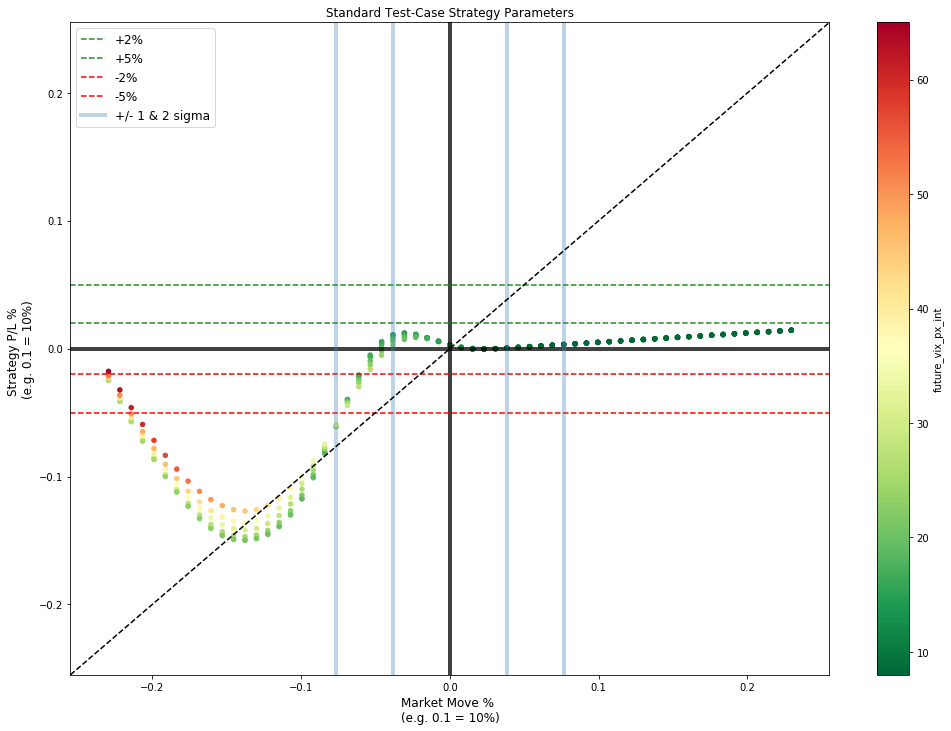

In [45]:
plot_opt_subplot(opt_result=temp_opt_res, ax_subplot=None, 
                 title_subplot='Standard Test-Case Strategy Parameters', 
                 simple_plot=True, use_norm_returns=True)

In [46]:
def perf_by_sigma_bands(strat_run, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=False):
    
    perf = strat_run.copy()
    
    sigma_bands = {}
    
    returns_type = 'port_pct_pnl'
    if use_norm_returns:
        print("Normalizing returns to a max drawdown of 15%\n" )
        returns_type = 'port_pct_pnl_norm_maxdd15'
        
    ## DOWN MARKET STATS  ###
    band_stats = {}
    move_to_price_EV_lo = -6.25 * mkt_implied_1sigma_move
    move_to_price_EV_hi = -2.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.045 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-6.0_-2.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = -2.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = -1.5 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.089 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-2.0_-1.5_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = -1.5 * mkt_implied_1sigma_move
    move_to_price_EV_hi = -1.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.182 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-1.5_-1.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = -1.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = -0.5 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.3 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-1.0_-0.5_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = -0.5 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 0.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.383 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-0.5_-0.0_sigma'] = band_stats

    
    ## UP MARKET STATS  ###
    band_stats = {}
    move_to_price_EV_lo = 2.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 6.25 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.045 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['2.0_6.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = 1.5 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 2.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.089 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['1.5_2.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = 1.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 1.5 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.182 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['1.0_1.5_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = 0.5 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 1.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.3 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['0.5_1.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = 0.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 0.5 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.383 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['0.0_0.5_sigma'] = band_stats
    
    print("Max DD: ", perf.port_pct_pnl.min())
    #print("Max DD normalized to -15%: ", perf.port_pct_pnl_norm_maxdd15.min())
    
    return pd.DataFrame(sigma_bands).T


In [47]:
perf_sig = perf_by_sigma_bands(temp_opt_res, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=True)
print('EV sum:', perf_sig['EV_rough'].sum())

perf_sig

Normalizing returns to a max drawdown of 15%

Max DD:  -0.15666077958441252
EV sum: -0.011035595039689426


,ann_return,interval,interval_start,interval_end,prob,EV_rough
-6.0_-2.0_sigma,-0.968468,"(-0.23908970961833526, -0.07650870707786728)",-0.23909,-0.0765087,0.0225,-0.0217905
-2.0_-1.5_sigma,-0.391889,"(-0.07650870707786728, -0.05738153030840046)",-0.0765087,-0.0573815,0.0445,-0.017439
-1.5_-1.0_sigma,-0.0370689,"(-0.05738153030840046, -0.03825435353893364)",-0.0573815,-0.0382544,0.091,-0.00337327
-1.0_-0.5_sigma,0.0888604,"(-0.03825435353893364, -0.01912717676946682)",-0.0382544,-0.0191272,0.15,0.0133291
-0.5_-0.0_sigma,0.0652629,"(-0.01912717676946682, 0.0)",-0.0191272,0,0.1915,0.0124978
2.0_6.0_sigma,0.0822609,"(0.07650870707786728, 0.23908970961833526)",0.0765087,0.23909,0.0225,0.00185087
1.5_2.0_sigma,0.0223674,"(0.05738153030840046, 0.07650870707786728)",0.0573815,0.0765087,0.0445,0.000995348
1.0_1.5_sigma,0.00943115,"(0.03825435353893364, 0.05738153030840046)",0.0382544,0.0573815,0.091,0.000858234
0.5_1.0_sigma,-0.0015224,"(0.01912717676946682, 0.03825435353893364)",0.0191272,0.0382544,0.15,-0.000228361
0.0_0.5_sigma,0.0118237,"(0.0, 0.01912717676946682)",0,0.0191272,0.1915,0.00226425


# Bayesian Optimization 

In [48]:
import sys
sys.path.append("./")
import bayes_opt
from bayes_opt import BayesianOptimization

In [49]:
def strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=None, lower_std_band=-1.5, upper_std_band=1.5, EV_only=False
                           ):
        
    
    if mkt_bias == 'flat':
        lower_std_band = -1.5
        upper_std_band = 1.5
        
    if mkt_bias == 'up':
        lower_std_band = -0.5
        upper_std_band = 2.0
        
    if mkt_bias == 'down':
        lower_std_band = -2.0
        upper_std_band = 0.5

    #print(lower_std_band, upper_std_band)
        
    opt_run_inputs = [short_p_1_n,
                      long_p_1_n,
                      long_p_2_n,
                      long_p_3_n,
                      
                      short_p_1_m,
                      long_p_1_m,
                      long_p_2_m,
                      long_p_3_m,
                      
                      short_u_hr,
                      long_c_1_hf,
                      exp_factor
        
                     ]
    
    strat_run = single_opt_run(opt_run_inputs=opt_run_inputs)
    
    perf = strat_run.copy()
    max_dd = perf.port_pct_pnl.min()
        
    results = {}
    
    if EV_only:

        move_to_price_EV_lo = -0.5 * mkt_implied_1sigma_move
        move_to_price_EV_hi = 0.5 * mkt_implied_1sigma_move
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_0.5_sigma'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = -1. * mkt_implied_1sigma_move
        move_to_price_EV_hi = 1. * mkt_implied_1sigma_move
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_1_sigma'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = -2. * mkt_implied_1sigma_move
        move_to_price_EV_hi = 2. * mkt_implied_1sigma_move
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_2_sigma'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = 0.0
        move_to_price_EV_hi = 0.03
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_up_0_3pct'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = 0.030001
        move_to_price_EV_hi = 0.15
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_up_3_15pct'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = -0.025
        move_to_price_EV_hi = 0.025
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_up_-2.5_2.5_pct'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        # obj_func_result = results['ann_2_sigma']
        #obj_func_result = results['ann_2_sigma'] + results['ann_0.5_sigma'] )

        # This obj func effectively places more emphasis on expected returns based on approx 1-2sigma moves in the underlying
        # A constraint follows which throws out portfolios with excessive risk based on the maximum potential drawdown
        #obj_func_result = np.mean( [results['ann_0.5_sigma'],
        avg_sigma_returns = np.mean( [results['ann_0.5_sigma'],
                                      results['ann_1_sigma'], 
                                      #results['ann_2_sigma'], 
                                      results['ann_up_0_3pct'], 
                                      results['ann_up_-2.5_2.5_pct'] ] ) 

        perf_sig = perf_by_sigma_bands(strat_run, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice)

        #obj_func_result = ( perf_sig['EV_rough'].sum() + avg_sigma_returns ) / 2.0
        EV_normalized_to_worst_acceptable_max_dd = ( perf_sig['EV_rough'].sum() ) * ( 0.15 / abs(max_dd))
        #obj_func_result = ( perf_sig['EV_rough'].sum() + avg_sigma_returns ) / abs(max_dd)
        obj_func_result = avg_sigma_returns + EV_normalized_to_worst_acceptable_max_dd

        
    else: 
        
        move_to_price_EV_lo = lower_std_band * mkt_implied_1sigma_move
        move_to_price_EV_hi = upper_std_band * mkt_implied_1sigma_move
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        
        slice_agg_returns = perf_slice.port_pct_pnl.sum()
        slice_std = perf_slice.port_pct_pnl.std()
        
        #obj_func_result = obj_func_result / slice_std
        #obj_func_result = obj_func_result + slice_agg_returns
        
        # TO-DO: try to replace with annual returns normalized to 0.15 max_dd and scaled by slide_std
        #obj_func_result = ( slice_agg_returns * ( 0.15 / abs(max_dd) ) ) / slice_std   # "psuedu-normalize" performance to same amount of max drawdown acceptable, and penalize for high std across range of values
        #obj_func_result = slice_agg_returns * ( 0.15 / abs(max_dd) )
        
        X = perf_slice.port_pct_pnl
        Y = np.ones(len(X)) * np.mean(X)
        regr = sm.OLS(Y, X).fit()
        flatness_across_range = abs(regr.rsquared_adj)
        #print( Y[0], flatness_across_range)
        
        flatness_disc_factor = 1.0
        
        obj_func_result = ( slice_agg_returns * ( 0.15 / abs(max_dd) ) ) * flatness_across_range * flatness_disc_factor
        
        
    return obj_func_result



##### WRAPPERS FOR ABOVE OBJECTIVE FUNCTION ##############################################################

def strat_obj_func_maximize_wrapper_UP(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias='up', lower_std_band=None, upper_std_band=None, EV_only=False
                           ):
    
    return strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=mkt_bias, lower_std_band=lower_std_band, upper_std_band=lower_std_band, EV_only=EV_only
                           )

def strat_obj_func_maximize_wrapper_DOWN(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias='down', lower_std_band=None, upper_std_band=None, EV_only=False
                           ):
    
    return strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=mkt_bias, lower_std_band=lower_std_band, upper_std_band=lower_std_band, EV_only=EV_only
                           )

def strat_obj_func_maximize_wrapper_FLAT(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias='flat', lower_std_band=None, upper_std_band=None, EV_only=False
                           ):
    
    return strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=mkt_bias, lower_std_band=lower_std_band, upper_std_band=lower_std_band, EV_only=EV_only
                           )


def strat_obj_func_maximize_wrapper_CUSTOM(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=None, lower_std_band=-1.5, upper_std_band=0.5, EV_only=False
                           ):
    
    return strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=mkt_bias, lower_std_band=lower_std_band, upper_std_band=upper_std_band, EV_only=EV_only
                           )

In [55]:
try:
    del bo_strat
except:
    pass

try:
    del bo_strat_stage_2
except:
    pass


strat_params = {}

strat_params['short_p_1_n'] = (-1.00, -1.00)
strat_params['long_p_1_n'] =  ( 0.65, 0.90)
strat_params['long_p_2_n'] =  ( 0.45,  0.80)
strat_params['long_p_3_n'] =  ( 0.00,  0.75)
                      
strat_params['short_p_1_m'] = (0.94,  0.98)
strat_params['long_p_1_m'] =  (0.88,  0.93)
strat_params['long_p_2_m'] =  (0.81,  0.87)
strat_params['long_p_3_m'] =  (0.70,  0.80)
                      
strat_params['short_u_hr'] =  (-1.5, -1.0)
strat_params['long_c_1_hf'] = (1.0, 2.0)
#strat_params['exp_factor'] =  (2.0, 7.0)
strat_params['exp_factor'] =  (5.0, 5.0)

strat_params_stage_1 = strat_params

#bo_strat = BayesianOptimization(strat_obj_func_maximize, strat_params)
#bo_strat = BayesianOptimization(strat_obj_func_maximize_wrapper_FLAT, strat_params)
bo_strat = BayesianOptimization(strat_obj_func_maximize_wrapper_CUSTOM, strat_params)

strat_params_explore = {}

# [ -1.0, 0.75, 0.5, 0.0,  .965, 0.9, 0.85, 0.80,    -1.5, 1.1, 4.0 ]  # standard OK values

strat_params_explore['short_p_1_n'] = [ -1.0, -1.0,     -1.0 ]
strat_params_explore['long_p_1_n'] =  [ 0.75, 0.7,      0.75 ]
strat_params_explore['long_p_2_n'] =  [ 0.50, 0.6,      0.5 ]
strat_params_explore['long_p_3_n'] =  [ 0.10, 0.02,     0.0 ]
                      
strat_params_explore['short_p_1_m'] = [ 0.96, 0.95,     0.965 ]
strat_params_explore['long_p_1_m'] =  [ 0.91, 0.90,     0.90 ]
strat_params_explore['long_p_2_m'] =  [ 0.85, 0.86,     0.85 ]
strat_params_explore['long_p_3_m'] =  [ 0.80, 0.75,     0.80]
                      
strat_params_explore['short_u_hr'] =   [ -1.1, -1.25,  -1.5]
strat_params_explore['long_c_1_hf'] =  [ 1.5, 1.25,     1.1 ]
strat_params_explore['exp_factor'] =   [ 4.0, 5.0,      4.5 ]

strat_params_explore  = [ -1.0, 0.75, 0.5, 0.0,  .965, 0.9, 0.85, 0.80,    -1.5, 1.1, 4.0 ]  # standard OK values
strat_params_explore_stage_1 = strat_params_explore

#bo_strat.explore( strat_params_explore )
bo_strat.probe( strat_params_explore )
#bo_strat.maximize(init_points=25, n_iter=200, acq="ei", xi=0.05)   # 0.0=exploit,  0.1=explore
#bo_strat.maximize(init_points=25, n_iter=200, acq="ei", xi=0.066)   # 0.0=exploit,  0.1=explore
#bo_strat.maximize(init_points=25, n_iter=150, acq="ei", xi=0.075)   # 0.0=exploit,  0.1=explore

#bo_strat.maximize(init_points=25, n_iter=100, acq='ucb', kappa=3)     # 1.0=exploit, 10.0=explore
bo_strat.maximize(init_points=25, n_iter=100, acq="poi", xi=0.03)   # 0.0=exploit,  0.1=explore


|   iter    |  target   | exp_fa... | long_c... | long_p... | long_p... | long_p... | long_p... | long_p... | long_p... | short_... | short_... | short_... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.05405  | -1.0      |  0.75     |  0.5      |  0.0      |  0.965    |  0.9      |  0.85     |  0.8      | -1.5      |  1.1      |  4.0      |
|  2        | -0.005777 |  5.0      |  1.905    |  0.9011   |  0.768    |  0.8369   |  0.7454   |  0.7273   |  0.2382   |  0.9597   | -1.0      | -1.424    |
|  3        | -0.008039 |  5.0      |  1.128    |  0.8971   |  0.6915   |  0.8144   |  0.6474   |  0.7669   |  0.4777   |  0.9787   | -1.0      | -1.198    |
|  4        | -0.02147  |  5.0      |  1.8      |  0.8892   |  0.8829   |  0.8378   |  0.4753   |  0.754    |  0.5301   |  0.9676   | -1.0      | -1.325    |
|  5        |  0.009711 |  5.0      |  1.609    |  0

In [56]:
7-3

4

In [76]:
bo_strat.max

{'target': 0.15011024091067132,
 'params': {'exp_factor': 5.0,
  'long_c_1_hf': 1.0,
  'long_p_1_m': 0.88,
  'long_p_1_n': 0.65,
  'long_p_2_m': 0.87,
  'long_p_2_n': 0.45,
  'long_p_3_m': 0.7,
  'long_p_3_n': 0.5259843040260377,
  'short_p_1_m': 0.94,
  'short_p_1_n': -1.0,
  'short_u_hr': -1.5}}

In [83]:
bo_strat.res[0]

{'target': -0.05404851996695817,
 'params': {'exp_factor': -1.0,
  'long_c_1_hf': 0.75,
  'long_p_1_m': 0.5,
  'long_p_1_n': 0.0,
  'long_p_2_m': 0.965,
  'long_p_2_n': 0.9,
  'long_p_3_m': 0.85,
  'long_p_3_n': 0.8,
  'short_p_1_m': -1.5,
  'short_p_1_n': 1.1,
  'short_u_hr': 4.0}}

In [70]:
def run_bo_result(bo_obj, run_type='max', trial_num=None):
    p = None
    opt_run_inputs = None
    
    if run_type == 'max':
        p = bo_obj.max['params']
    
    if run_type == 'bo_trial':
        p = bo_obj.res['all']['params'][trial_num]
        
    if (run_type == 'max') or (run_type == 'bo_trial'):
        opt_run_inputs = [ p['short_p_1_n'],
                           p['long_p_1_n'],
                           p['long_p_2_n'],
                           p['long_p_3_n'],

                           p['short_p_1_m'],
                           p['long_p_1_m'],
                           p['long_p_2_m'],
                           p['long_p_3_m'],

                           p['short_u_hr'],
                           p['long_c_1_hf'],
                           p['exp_factor'],

                         ] 
    
    if run_type == 'init_trial':
        opt_run_inputs = bo_obj.init_points[trial_num]
          
    return single_opt_run( opt_run_inputs=opt_run_inputs ) , opt_run_inputs 

In [71]:
bo_strat.max

{'target': 0.15011024091067132,
 'params': {'exp_factor': 5.0,
  'long_c_1_hf': 1.0,
  'long_p_1_m': 0.88,
  'long_p_1_n': 0.65,
  'long_p_2_m': 0.87,
  'long_p_2_n': 0.45,
  'long_p_3_m': 0.7,
  'long_p_3_n': 0.5259843040260377,
  'short_p_1_m': 0.94,
  'short_p_1_n': -1.0,
  'short_u_hr': -1.5}}

In [78]:
bo_strat.res[0]

{'target': -0.05404851996695817,
 'params': {'exp_factor': -1.0,
  'long_c_1_hf': 0.75,
  'long_p_1_m': 0.5,
  'long_p_1_n': 0.0,
  'long_p_2_m': 0.965,
  'long_p_2_n': 0.9,
  'long_p_3_m': 0.85,
  'long_p_3_n': 0.8,
  'short_p_1_m': -1.5,
  'short_p_1_n': 1.1,
  'short_u_hr': 4.0}}

[-1.0, 0.65, 0.45, 0.5259843040260377, 0.94, 0.88, 0.87, 0.7, -1.5, 1.0, 5.0]


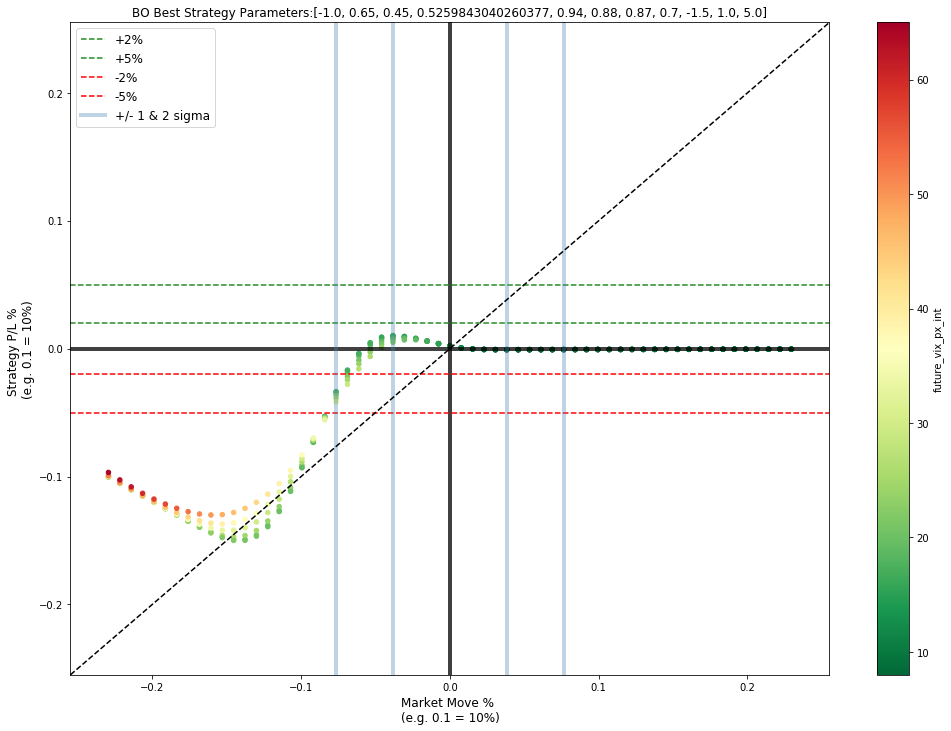

In [72]:
#strat_params = [-1.0, 0.669, 0.347, 0.0, 0.978, 0.917, 0.79, 0.82, -1.0, 1.111, 3.933 ]  # VERY intersteding
# strat_params = [ -1.0, 0.75, 0.5, 0.0,  .965, 0.9, 0.85, 0.80,    -1.5, 1.1, 4.0 ]  # typical initial

temp_opt_res, strat_params = run_bo_result(bo_strat)
#temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='init_trial', trial_num=2 )
#temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='bo_trial', trial_num=int(59-23) )

print(strat_params)

plot_opt_subplot(opt_result=temp_opt_res, ax_subplot=None, title_subplot='BO Best Strategy Parameters:'+str(strat_params), simple_plot=True)

In [73]:
perf_sig = perf_by_sigma_bands(temp_opt_res, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=True)
print('EV sum:', perf_sig['EV_rough'].sum())

perf_sig

Normalizing returns to a max drawdown of 15%

Max DD:  -0.2231420376494628
EV sum: -0.011388455947075049


,ann_return,interval,interval_start,interval_end,prob,EV_rough
-6.0_-2.0_sigma,-1.09185,"(-0.23908970961833526, -0.07650870707786728)",-0.23909,-0.0765087,0.0225,-0.0245667
-2.0_-1.5_sigma,-0.205817,"(-0.07650870707786728, -0.05738153030840046)",-0.0765087,-0.0573815,0.0445,-0.00915887
-1.5_-1.0_sigma,0.0300897,"(-0.05738153030840046, -0.03825435353893364)",-0.0573815,-0.0382544,0.091,0.00273816
-1.0_-0.5_sigma,0.0761154,"(-0.03825435353893364, -0.01912717676946682)",-0.0382544,-0.0191272,0.15,0.0114173
-0.5_-0.0_sigma,0.0457187,"(-0.01912717676946682, 0.0)",-0.0191272,0,0.1915,0.00875513
2.0_6.0_sigma,-0.00519367,"(0.07650870707786728, 0.23908970961833526)",0.0765087,0.23909,0.0225,-0.000116858
1.5_2.0_sigma,-0.00692158,"(0.05738153030840046, 0.07650870707786728)",0.0573815,0.0765087,0.0445,-0.00030801
1.0_1.5_sigma,-0.00725099,"(0.03825435353893364, 0.05738153030840046)",0.0382544,0.0573815,0.091,-0.00065984
0.5_1.0_sigma,-0.0064898,"(0.01912717676946682, 0.03825435353893364)",0.0191272,0.0382544,0.15,-0.00097347
0.0_0.5_sigma,0.00775281,"(0.0, 0.01912717676946682)",0,0.0191272,0.1915,0.00148466


In [74]:
def get_top_opt_results(opt_result, top_n=10):
    
    val_list = opt_result.res['all']['values']
    top_idx = sorted(range(len(val_list)), key=lambda i: val_list[i], reverse=True)[:top_n]
    
    return top_idx


def plot_bo_results( bo_strat, strat_params_explore, max_explore_plots=3, subplots_total=16, subplot_cols=2, figsize=(30, 80), plot_hspace=0.35):
    
    matplotlib.rcParams['figure.figsize'] = figsize

    subplot_rows = int( subplots_total / subplot_cols)
    subplot_coord = [(row, col) for row in range(subplot_rows) for col in range(subplot_cols)]

    f, axarr = plt.subplots(subplot_rows, subplot_cols)
    
    count = 0
    count_explore = 0
    count_best_bo = 0

    num_explore_combos = None
    if max_explore_plots is None:
        num_explore_combos = len( strat_params_explore[ list(strat_params_explore.keys())[0] ] )
    else:
        num_explore_combos = max_explore_plots

    top_opt_results_idx = get_top_opt_results(bo_strat, top_n=subplots_total)

    for ax_coord in subplot_coord:
        ax_plot_done = False

        if count == 0: 
            temp_opt_res, strat_params = run_bo_result(bo_strat)
            plot_opt_subplot( opt_result=temp_opt_res, ax_subplot=axarr[ ax_coord[0], ax_coord[1] ], title_subplot='(' + str(count) + ')  ' + 'Best Optimization Result \n' + str(np.round(strat_params,2)) + '\n Obj Func Val=' + str(np.round(bo_strat.res['max']['max_val'],4)) )
            ax_plot_done = True

        if not ax_plot_done:
            if count_explore < num_explore_combos:
                temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='init_trial', trial_num=count_explore )
                plot_opt_subplot( opt_result=temp_opt_res, ax_subplot=axarr[ ax_coord[0], ax_coord[1] ], title_subplot='(' + str(count) + ')  ' + 'Explore Result: ' + str(count_explore+1) + '\n' + str(np.round(strat_params,2)) )
                count_explore = count_explore + 1
                ax_plot_done = True

        if not ax_plot_done:
            temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='bo_trial', trial_num=top_opt_results_idx[count_best_bo] )
            temp_obj_val = bo_strat.res['all']['values'][ top_opt_results_idx[count_best_bo] ]
            plot_opt_subplot( opt_result=temp_opt_res, ax_subplot=axarr[ ax_coord[0], ax_coord[1] ], title_subplot='(' + str(count) + ')  ' + 'BO Result: ' + str(count_best_bo+1) + '\n' + str(np.round(strat_params,2)) + '\n Obj Func Val=' + str(np.round(temp_obj_val,4)) )
            count_best_bo = count_best_bo + 1
            ax_plot_done = True


        count = count + 1

    print('Bayesian Optimization Results. Following top results are based on your objective function specified Market Move range. \n All returns plotted are normalized to a max drawdown of 15%.')

    plt.subplots_adjust(hspace=plot_hspace)

TypeError: list indices must be integers or slices, not str

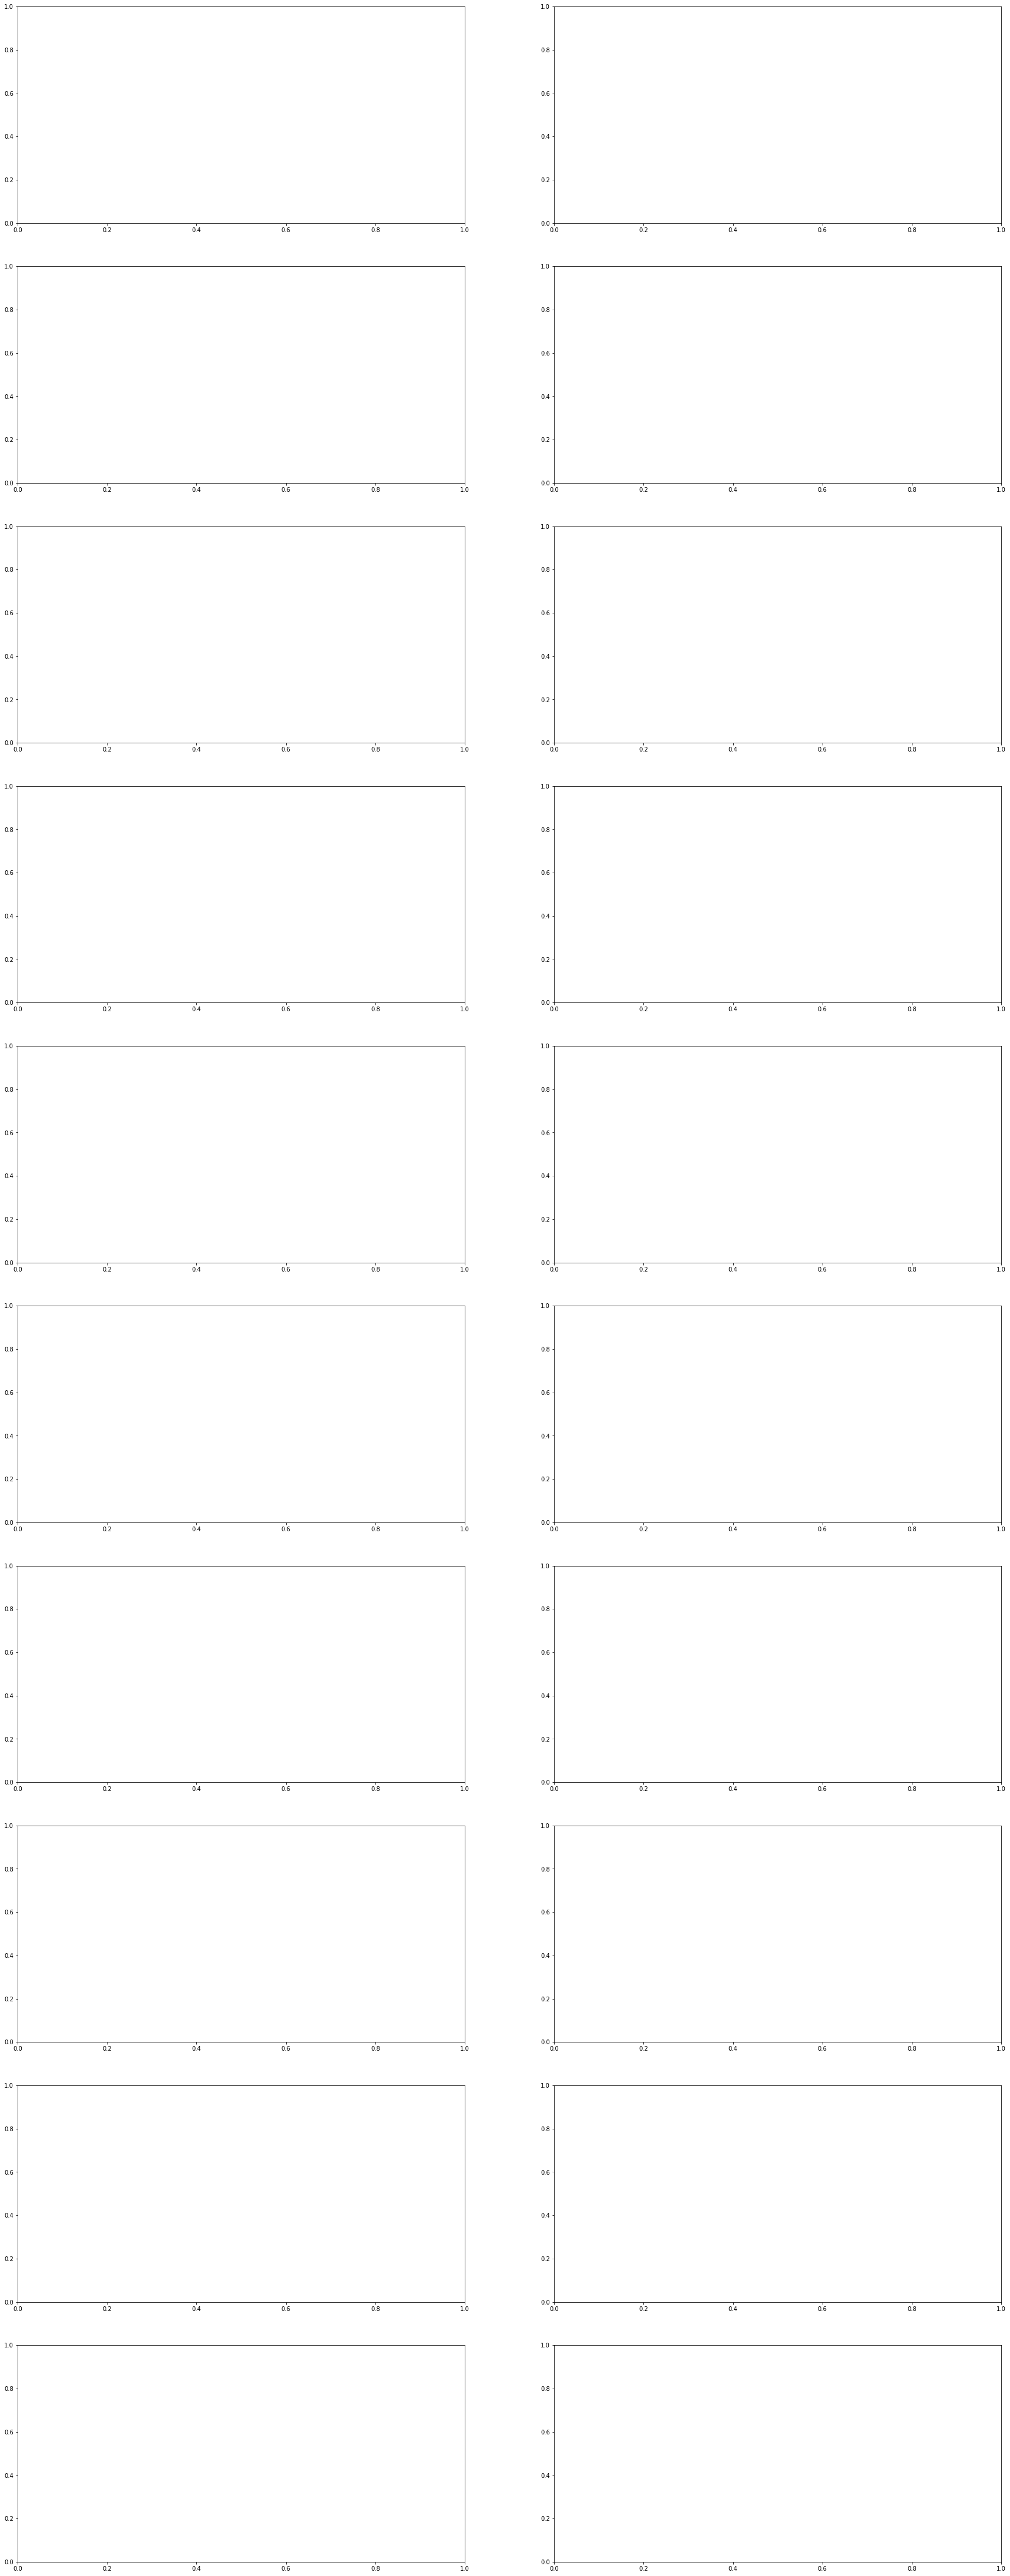

In [75]:
plot_bo_results(bo_strat=bo_strat, strat_params_explore=strat_params_explore, 
                subplots_total=20, figsize=(30,80), plot_hspace=0.35)

In [105]:
top_opt_params = {}

bo_num_trials = len( bo_strat.res['all']['params'] )

for param_name in bo_strat.res['all']['params'][0]:
    top_opt_params[param_name] = []

for param_name in bo_strat.res['all']['params'][0]:
    for top_idx in get_top_opt_results(bo_strat, top_n=int(bo_num_trials * 0.10)):
        top_opt_params[param_name].append( bo_strat.res['all']['params'][top_idx][param_name] )
        
top_opt_params_range = {}  
range_pad_pct = .1
for param_name in top_opt_params:
    range_min = np.min(top_opt_params[param_name])
    range_max = np.max(top_opt_params[param_name])
    
    range_diff = range_max - range_min
    range_pad_amt = range_diff * range_pad_pct
    
    top_opt_params_range[ param_name ] = ( max(range_min - range_pad_amt, strat_params_stage_1[param_name][0]) , min(range_max + range_pad_amt, strat_params_stage_1[param_name][1]) )
        

In [106]:
top_opt_params_range

{'exp_factor': (5.0, 5.0),
 'long_c_1_hf': (1.0, 1.5090377870060172),
 'long_p_1_m': (0.88, 0.8964328956149841),
 'long_p_1_n': (0.65, 0.8440405786956301),
 'long_p_2_m': (0.81, 0.87),
 'long_p_2_n': (0.45, 0.8),
 'long_p_3_m': (0.7, 0.8),
 'long_p_3_n': (0.0, 0.44012768760889337),
 'short_p_1_m': (0.94, 0.9453107358922238),
 'short_p_1_n': (-1.0, -1.0),
 'short_u_hr': (-1.5, -1.1664001458775295)}

In [107]:
####### STAGE 2 BO ####
try:
    del bo_strat_stage_2
except:
    pass

#bo_strat_stage_2 = BayesianOptimization(strat_obj_func_maximize_wrapper_FLAT, top_opt_params_range)
bo_strat_stage_2 = BayesianOptimization(strat_obj_func_maximize_wrapper_CUSTOM, top_opt_params_range)

strat_params_explore_stage_2 = top_opt_params
bo_strat_stage_2.explore( strat_params_explore_stage_2 )

#bo_strat_stage_2.maximize(init_points=20, n_iter=200, acq="ei", xi=0.033)   # 0.0=exploit,  0.1=explore
bo_strat_stage_2.maximize(init_points=20, n_iter=150, acq="ei", xi=0.01)   # 0.0=exploit,  0.1=explore

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   exp_factor |   long_c_1_hf |   long_p_1_m |   long_p_1_n |   long_p_2_m |   long_p_2_n |   long_p_3_m |   long_p_3_n |   short_p_1_m |   short_p_1_n |   short_u_hr | 
    1 | 00m01s |    0.22376 |       5.0000 |        1.0000 |       0.8800 |       0.6500 |       0.8700 |       0.4500 |       0.7000 |       0.1906 |        0.9400 |       -1.0000 |      -1.5000 | 
    2 | 00m01s |    0.21938 |       5.0000 |        1.0000 |       0.8800 |       0.6500 |       0.8100 |       0.4500 |       0.8000 |       0.1085 |        0.9400 |       -1.0000 |      -1.5000 | 
    3 | 00m01s |    0.21849 |       5.0000 |        1.0398 |       0.8826 |       0.7042 |       0.8103 |       0.4543 |       0.7521 |       0.0046 |        0.9408 |       -1.0000 |      -1

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010217]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   55 | 00m03s |    0.08078 |       5.0000 |        1.5009 |       0.8836 |       0.6501 |       0.8107 |       0.7662 |       0.7860 |       0.4401 |        0.9417 |       -1.0000 |      -1.4421 | 
   56 | 00m03s |    0.10916 |       5.0000 |        1.0086 |       0.8947 |       0.8226 |       0.8100 |       0.7998 |       0.7071 |       0.4185 |        0.9436 |       -1.0000 |      -1.4938 | 
   57 | 00m03s |    0.19432 |       5.0000 |        1.1537 |       0.8928 |       0.6535 |       0.8312 |       0.4593 |       0.7026 |       0.3546 |        0.9411 |       -1.0000 |      -1.4991 | 
   58 | 00m03s |    0.20495 |       5.0000 |        1.0009 |       0.8801 |       0.6664 |       0.8119 |       0.5573 |       0.7102 |       0.0011 |        0.9433 |       -1.0000 |      -1.4927 | 
   59 | 00m03s |    0.10032 |       5.0000 |        1.0232 |       0.8953 |       0.6597 |       0.8242 |       0.7905 |       0.7250 |       0.0001 |        0.9417 |       -1.0000 |      -1.1950 | 
   60

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0001013]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   62 | 00m03s |    0.11144 |       5.0000 |        1.0036 |       0.8953 |       0.8368 |       0.8133 |       0.4665 |       0.7371 |       0.0061 |        0.9416 |       -1.0000 |      -1.1784 | 
   63 | 00m03s |    0.20408 |       5.0000 |        1.0086 |       0.8876 |       0.7615 |       0.8130 |       0.4546 |       0.7066 |       0.1195 |        0.9433 |       -1.0000 |      -1.4992 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.66738313e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


   64 | 00m03s |    0.21057 |       5.0000 |        1.0026 |       0.8937 |       0.6526 |       0.8700 |       0.4607 |       0.7412 |       0.0358 |        0.9402 |       -1.0000 |      -1.3845 | 
   65 | 00m03s |    0.20371 |       5.0000 |        1.0467 |       0.8873 |       0.8011 |       0.8418 |       0.4533 |       0.7132 |       0.0028 |        0.9404 |       -1.0000 |      -1.4991 | 
   66 | 00m03s |    0.21184 |       5.0000 |        1.0106 |       0.8902 |       0.6863 |       0.8680 |       0.5026 |       0.7895 |       0.0098 |        0.9412 |       -1.0000 |      -1.4942 | 
   67 | 00m03s |    0.14825 |       5.0000 |        1.5008 |       0.8925 |       0.6612 |       0.8110 |       0.4970 |       0.7043 |       0.2510 |        0.9401 |       -1.0000 |      -1.4920 | 
   68 | 00m03s |    0.21682 |       5.0000 |        1.0633 |       0.8877 |       0.6597 |       0.8214 |       0.4714 |       0.7969 |       0.0509 |        0.9406 |       -1.0000 |      -1.4956 | 
   69

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010994]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   77 | 00m03s |    0.07597 |       5.0000 |        1.4949 |       0.8864 |       0.6539 |       0.8281 |       0.7930 |       0.7022 |       0.0035 |        0.9422 |       -1.0000 |      -1.2094 | 
   78 | 00m03s |    0.18867 |       5.0000 |        1.1006 |       0.8956 |       0.8254 |       0.8117 |       0.4717 |       0.7122 |       0.1848 |        0.9407 |       -1.0000 |      -1.4973 | 
   79 | 00m03s |    0.15062 |       5.0000 |        1.2351 |       0.8855 |       0.6503 |       0.8101 |       0.7881 |       0.7124 |       0.3836 |        0.9401 |       -1.0000 |      -1.4815 | 
   80 | 00m03s |    0.21873 |       5.0000 |        1.0180 |       0.8811 |       0.6611 |       0.8618 |       0.4584 |       0.7310 |       0.0017 |        0.9406 |       -1.0000 |      -1.4477 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00028625]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   81 | 00m03s |    0.19018 |       5.0000 |        1.0046 |       0.8960 |       0.6977 |       0.8566 |       0.4651 |       0.7064 |       0.4354 |        0.9402 |       -1.0000 |      -1.4974 | 
   82 | 00m03s |    0.20661 |       5.0000 |        1.0073 |       0.8871 |       0.6507 |       0.8684 |       0.5451 |       0.7109 |       0.0631 |        0.9404 |       -1.0000 |      -1.4949 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00020165]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   83 | 00m03s |    0.23329 |       5.0000 |        1.0201 |       0.8910 |       0.6558 |       0.8619 |       0.4583 |       0.7569 |       0.0050 |        0.9404 |       -1.0000 |      -1.4971 | 
   84 | 00m03s |    0.12029 |       5.0000 |        1.1999 |       0.8801 |       0.8229 |       0.8189 |       0.4572 |       0.7282 |       0.4128 |        0.9401 |       -1.0000 |      -1.1704 | 
   85 | 00m03s |    0.15666 |       5.0000 |        1.1349 |       0.8869 |       0.6566 |       0.8164 |       0.4539 |       0.7921 |       0.1437 |        0.9404 |       -1.0000 |      -1.1947 | 
   86 | 00m03s |    0.18914 |       5.0000 |        1.3761 |       0.8928 |       0.6555 |       0.8340 |       0.4584 |       0.7980 |       0.0033 |        0.9412 |       -1.0000 |      -1.4998 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00063711]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   87 | 00m03s |    0.15782 |       5.0000 |        1.0039 |       0.8842 |       0.6655 |       0.8210 |       0.7810 |       0.7812 |       0.4200 |        0.9415 |       -1.0000 |      -1.4995 | 
   88 | 00m03s |    0.04467 |       5.0000 |        1.5048 |       0.8927 |       0.8383 |       0.8139 |       0.7990 |       0.7423 |       0.4329 |        0.9441 |       -1.0000 |      -1.4810 | 
   89 | 00m03s |    0.20333 |       5.0000 |        1.1969 |       0.8809 |       0.6542 |       0.8663 |       0.4829 |       0.7075 |       0.0016 |        0.9415 |       -1.0000 |      -1.4968 | 
   90 | 00m03s |    0.14666 |       5.0000 |        1.4965 |       0.8902 |       0.6600 |       0.8175 |       0.4555 |       0.7971 |       0.0292 |        0.9411 |       -1.0000 |      -1.3379 | 
   91 | 00m03s |    0.17590 |       5.0000 |        1.0043 |       0.8817 |       0.6673 |       0.8593 |       0.4516 |       0.7973 |       0.3559 |        0.9429 |       -1.0000 |      -1.4955 | 
   92

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010231]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


   96 | 00m04s |    0.07501 |       5.0000 |        1.0130 |       0.8833 |       0.8411 |       0.8136 |       0.7936 |       0.7992 |       0.4107 |        0.9413 |       -1.0000 |      -1.1925 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00048447]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   97 | 00m03s |    0.01192 |       5.0000 |        1.5031 |       0.8885 |       0.8398 |       0.8376 |       0.7826 |       0.7988 |       0.4154 |        0.9402 |       -1.0000 |      -1.1667 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00077542]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   98 | 00m03s |    0.16132 |       5.0000 |        1.0031 |       0.8826 |       0.8349 |       0.8227 |       0.4538 |       0.7984 |       0.2264 |        0.9402 |       -1.0000 |      -1.3342 | 
   99 | 00m03s |    0.21355 |       5.0000 |        1.1510 |       0.8806 |       0.6625 |       0.8485 |       0.4514 |       0.7905 |       0.0115 |        0.9401 |       -1.0000 |      -1.4771 | 
  100 | 00m03s |    0.09182 |       5.0000 |        1.2877 |       0.8819 |       0.6522 |       0.8183 |       0.7815 |       0.7858 |       0.3933 |        0.9404 |       -1.0000 |      -1.1673 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00036888]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  101 | 00m03s |    0.08523 |       5.0000 |        1.0015 |       0.8881 |       0.8128 |       0.8649 |       0.7945 |       0.7851 |       0.0057 |        0.9408 |       -1.0000 |      -1.4961 | 
  102 | 00m03s |    0.01913 |       5.0000 |        1.4527 |       0.8948 |       0.8432 |       0.8660 |       0.4505 |       0.7090 |       0.4348 |        0.9441 |       -1.0000 |      -1.1939 | 
  103 | 00m04s |    0.18563 |       5.0000 |        1.0372 |       0.8963 |       0.8114 |       0.8107 |       0.6092 |       0.7272 |       0.0009 |        0.9407 |       -1.0000 |      -1.4867 | 
  104 | 00m04s |    0.16602 |       5.0000 |        1.2219 |       0.8804 |       0.6645 |       0.8222 |       0.4506 |       0.7033 |       0.4365 |        0.9409 |       -1.0000 |      -1.3542 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00014931]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  105 | 00m04s |    0.14612 |       5.0000 |        1.0081 |       0.8851 |       0.6704 |       0.8688 |       0.4590 |       0.7985 |       0.0213 |        0.9422 |       -1.0000 |      -1.2295 | 
  106 | 00m03s |    0.10353 |       5.0000 |        1.0281 |       0.8841 |       0.7393 |       0.8152 |       0.4629 |       0.7968 |       0.4344 |        0.9426 |       -1.0000 |      -1.1733 | 
  107 | 00m04s |    0.13883 |       5.0000 |        1.5011 |       0.8832 |       0.6740 |       0.8602 |       0.4504 |       0.7946 |       0.0033 |        0.9428 |       -1.0000 |      -1.4830 | 
  108 | 00m04s |    0.13974 |       5.0000 |        1.0017 |       0.8860 |       0.6526 |       0.8117 |       0.6378 |       0.7032 |       0.2514 |        0.9417 |       -1.0000 |      -1.2215 | 
  109 | 00m04s |    0.14887 |       5.0000 |        1.3372 |       0.8803 |       0.7128 |       0.8108 |       0.7982 |       0.7208 |       0.0165 |        0.9403 |       -1.0000 |      -1.4850 | 
  110

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00042712]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


  112 | 00m04s |    0.14465 |       5.0000 |        1.4073 |       0.8857 |       0.6611 |       0.8231 |       0.4597 |       0.7036 |       0.0011 |        0.9403 |       -1.0000 |      -1.1864 | 
  113 | 00m04s |    0.18474 |       5.0000 |        1.2439 |       0.8912 |       0.7154 |       0.8108 |       0.4515 |       0.7028 |       0.2561 |        0.9412 |       -1.0000 |      -1.4952 | 
  114 | 00m04s |    0.19741 |       5.0000 |        1.0127 |       0.8801 |       0.6836 |       0.8201 |       0.7007 |       0.7058 |       0.0088 |        0.9400 |       -1.0000 |      -1.4995 | 
  115 | 00m04s |    0.15600 |       5.0000 |        1.2788 |       0.8934 |       0.6510 |       0.8145 |       0.6024 |       0.7072 |       0.4217 |        0.9407 |       -1.0000 |      -1.4973 | 
  116 | 00m04s |    0.04850 |       5.0000 |        1.1320 |       0.8887 |       0.8400 |       0.8168 |       0.7851 |       0.7007 |       0.4294 |        0.9417 |       -1.0000 |      -1.1934 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00024714]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  117 | 00m04s |    0.12158 |       5.0000 |        1.0076 |       0.8880 |       0.8275 |       0.8141 |       0.4525 |       0.7043 |       0.3944 |        0.9416 |       -1.0000 |      -1.2397 | 
  118 | 00m04s |    0.12095 |       5.0000 |        1.3244 |       0.8826 |       0.6603 |       0.8110 |       0.7851 |       0.7959 |       0.0028 |        0.9405 |       -1.0000 |      -1.1718 | 
  119 | 00m04s |    0.04969 |       5.0000 |        1.4966 |       0.8865 |       0.8405 |       0.8107 |       0.7743 |       0.7852 |       0.0546 |        0.9428 |       -1.0000 |      -1.1904 | 
  120 | 00m04s |    0.09029 |       5.0000 |        1.3876 |       0.8805 |       0.8069 |       0.8159 |       0.7858 |       0.7973 |       0.1970 |        0.9434 |       -1.0000 |      -1.4995 | 
  121 | 00m04s |    0.16661 |       5.0000 |        1.0071 |       0.8810 |       0.7253 |       0.8119 |       0.6034 |       0.7975 |       0.4262 |        0.9406 |       -1.0000 |      -1.4873 | 
  122

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00023158]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  127 | 00m04s |    0.09962 |       5.0000 |        1.3318 |       0.8806 |       0.8339 |       0.8105 |       0.4589 |       0.7001 |       0.0065 |        0.9417 |       -1.0000 |      -1.1854 | 
  128 | 00m04s |    0.22298 |       5.0000 |        1.0358 |       0.8836 |       0.6626 |       0.8322 |       0.4528 |       0.7982 |       0.0043 |        0.9412 |       -1.0000 |      -1.4508 | 
  129 | 00m04s |    0.05794 |       5.0000 |        1.4717 |       0.8870 |       0.6519 |       0.8137 |       0.7796 |       0.7786 |       0.2326 |        0.9434 |       -1.0000 |      -1.1691 | 
  130 | 00m04s |    0.19987 |       5.0000 |        1.0784 |       0.8898 |       0.6536 |       0.8141 |       0.5583 |       0.7737 |       0.0043 |        0.9400 |       -1.0000 |      -1.4714 | 
  131 | 00m04s |    0.13507 |       5.0000 |        1.5066 |       0.8806 |       0.8389 |       0.8177 |       0.4525 |       0.7258 |       0.2007 |        0.9404 |       -1.0000 |      -1.4842 | 
  132

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00027744]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  138 | 00m04s |    0.11582 |       5.0000 |        1.0028 |       0.8822 |       0.8255 |       0.8153 |       0.7669 |       0.7878 |       0.0179 |        0.9410 |       -1.0000 |      -1.1697 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00128065]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


  139 | 00m04s |    0.19972 |       5.0000 |        1.0660 |       0.8801 |       0.7264 |       0.8172 |       0.4577 |       0.7083 |       0.2968 |        0.9413 |       -1.0000 |      -1.4908 | 
  140 | 00m04s |    0.16105 |       5.0000 |        1.0047 |       0.8959 |       0.6585 |       0.8171 |       0.7915 |       0.7822 |       0.1873 |        0.9400 |       -1.0000 |      -1.4867 | 
  141 | 00m04s |    0.14784 |       5.0000 |        1.0057 |       0.8886 |       0.6947 |       0.8139 |       0.4738 |       0.7942 |       0.2086 |        0.9401 |       -1.0000 |      -1.1675 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00102646]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  142 | 00m04s |    0.19005 |       5.0000 |        1.0002 |       0.8803 |       0.8310 |       0.8153 |       0.4525 |       0.7812 |       0.2824 |        0.9406 |       -1.0000 |      -1.4959 | 
  143 | 00m04s |    0.18078 |       5.0000 |        1.1265 |       0.8819 |       0.6527 |       0.8543 |       0.4597 |       0.7018 |       0.1803 |        0.9401 |       -1.0000 |      -1.3095 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00024987]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  144 | 00m05s |    0.22280 |       5.0000 |        1.0043 |       0.8871 |       0.6758 |       0.8313 |       0.4651 |       0.7982 |       0.0001 |        0.9401 |       -1.0000 |      -1.4672 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00031547]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  145 | 00m04s |    0.17669 |       5.0000 |        1.0399 |       0.8809 |       0.8245 |       0.8159 |       0.5583 |       0.7977 |       0.0352 |        0.9411 |       -1.0000 |      -1.3689 | 
  146 | 00m04s |    0.12685 |       5.0000 |        1.5023 |       0.8802 |       0.7375 |       0.8101 |       0.5617 |       0.7045 |       0.4300 |        0.9410 |       -1.0000 |      -1.4181 | 
  147 | 00m04s |    0.10548 |       5.0000 |        1.0017 |       0.8824 |       0.8430 |       0.8152 |       0.7919 |       0.7325 |       0.1972 |        0.9409 |       -1.0000 |      -1.2048 | 
  148 | 00m04s |    0.18593 |       5.0000 |        1.0092 |       0.8832 |       0.6519 |       0.8367 |       0.4754 |       0.7054 |       0.1325 |        0.9410 |       -1.0000 |      -1.2525 | 
  149 | 00m05s |    0.19863 |       5.0000 |        1.0053 |       0.8807 |       0.8281 |       0.8144 |       0.5369 |       0.7869 |       0.0783 |        0.9402 |       -1.0000 |      -1.4945 | 
  150

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00041008]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  151 | 00m05s |    0.16301 |       5.0000 |        1.3127 |       0.8800 |       0.6520 |       0.8256 |       0.6123 |       0.7010 |       0.2478 |        0.9400 |       -1.0000 |      -1.4941 | 
  152 | 00m05s |    0.15598 |       5.0000 |        1.3526 |       0.8874 |       0.6503 |       0.8123 |       0.5024 |       0.7047 |       0.0140 |        0.9417 |       -1.0000 |      -1.4689 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0005892]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  153 | 00m05s |    0.13700 |       5.0000 |        1.0233 |       0.8930 |       0.8324 |       0.8598 |       0.5136 |       0.7017 |       0.4390 |        0.9412 |       -1.0000 |      -1.4998 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00045564]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  154 | 00m05s |    0.14635 |       5.0000 |        1.0020 |       0.8814 |       0.6578 |       0.8123 |       0.7977 |       0.7139 |       0.1450 |        0.9402 |       -1.0000 |      -1.2140 | 
  155 | 00m04s |    0.21657 |       5.0000 |        1.0090 |       0.8808 |       0.6563 |       0.8177 |       0.4820 |       0.7841 |       0.0058 |        0.9432 |       -1.0000 |      -1.4992 | 
  156 | 00m04s |    0.10160 |       5.0000 |        1.4989 |       0.8866 |       0.6582 |       0.8112 |       0.4509 |       0.7136 |       0.1928 |        0.9416 |       -1.0000 |      -1.1902 | 
  157 | 00m05s |    0.13594 |       5.0000 |        1.3478 |       0.8819 |       0.8389 |       0.8118 |       0.4623 |       0.7997 |       0.2000 |        0.9411 |       -1.0000 |      -1.3940 | 
  158 | 00m04s |    0.11889 |       5.0000 |        1.4565 |       0.8828 |       0.6504 |       0.8235 |       0.6063 |       0.7408 |       0.0067 |        0.9405 |       -1.0000 |      -1.1734 | 
  159

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00209524]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  161 | 00m05s |    0.16589 |       5.0000 |        1.0106 |       0.8820 |       0.8250 |       0.8159 |       0.4548 |       0.7825 |       0.4281 |        0.9401 |       -1.0000 |      -1.4450 | 
  162 | 00m05s |    0.09043 |       5.0000 |        1.2151 |       0.8803 |       0.8367 |       0.8115 |       0.7264 |       0.7937 |       0.4333 |        0.9438 |       -1.0000 |      -1.4844 | 
  163 | 00m05s |    0.20200 |       5.0000 |        1.0979 |       0.8857 |       0.6514 |       0.8115 |       0.4511 |       0.7155 |       0.0298 |        0.9416 |       -1.0000 |      -1.4778 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00014085]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  164 | 00m05s |    0.20541 |       5.0000 |        1.0059 |       0.8841 |       0.6555 |       0.8190 |       0.4515 |       0.7201 |       0.3244 |        0.9421 |       -1.0000 |      -1.4963 | 
  165 | 00m05s |    0.14352 |       5.0000 |        1.0736 |       0.8823 |       0.8436 |       0.8111 |       0.7954 |       0.7914 |       0.1838 |        0.9401 |       -1.0000 |      -1.4824 | 
  166 | 00m05s |    0.18260 |       5.0000 |        1.2188 |       0.8801 |       0.8147 |       0.8150 |       0.4571 |       0.7012 |       0.1369 |        0.9409 |       -1.0000 |      -1.4977 | 
  167 | 00m05s |    0.12105 |       5.0000 |        1.1654 |       0.8826 |       0.8404 |       0.8235 |       0.4569 |       0.7884 |       0.2147 |        0.9405 |       -1.0000 |      -1.1698 | 
  168 | 00m05s |    0.12233 |       5.0000 |        1.1698 |       0.8801 |       0.6546 |       0.8132 |       0.6617 |       0.7491 |       0.4325 |        0.9415 |       -1.0000 |      -1.3097 | 
  169

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00040015]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  170 | 00m05s |    0.15679 |       5.0000 |        1.0038 |       0.8829 |       0.7496 |       0.8101 |       0.7975 |       0.7217 |       0.3027 |        0.9407 |       -1.0000 |      -1.4142 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00097724]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


  171 | 00m05s |    0.10727 |       5.0000 |        1.0028 |       0.8824 |       0.6521 |       0.8176 |       0.7825 |       0.7855 |       0.4370 |        0.9448 |       -1.0000 |      -1.2902 | 
  172 | 00m06s |    0.19128 |       5.0000 |        1.2049 |       0.8865 |       0.6610 |       0.8123 |       0.4503 |       0.7908 |       0.0213 |        0.9404 |       -1.0000 |      -1.3703 | 
  173 | 00m05s |    0.15647 |       5.0000 |        1.1942 |       0.8801 |       0.6551 |       0.8263 |       0.5033 |       0.7010 |       0.0285 |        0.9402 |       -1.0000 |      -1.1718 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00178856]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  174 | 00m06s |    0.15602 |       5.0000 |        1.2157 |       0.8804 |       0.6751 |       0.8143 |       0.7847 |       0.7966 |       0.0681 |        0.9404 |       -1.0000 |      -1.4789 | 
  175 | 00m05s |    0.18049 |       5.0000 |        1.0387 |       0.8802 |       0.6557 |       0.8144 |       0.5598 |       0.7954 |       0.0883 |        0.9403 |       -1.0000 |      -1.3168 | 
  176 | 00m05s |    0.15259 |       5.0000 |        1.4955 |       0.8819 |       0.6508 |       0.8156 |       0.5812 |       0.7997 |       0.0410 |        0.9400 |       -1.0000 |      -1.4953 | 
  177 | 00m05s |    0.11734 |       5.0000 |        1.4445 |       0.8849 |       0.6503 |       0.8101 |       0.6596 |       0.7059 |       0.4301 |        0.9403 |       -1.0000 |      -1.3162 | 
  178 | 00m05s |    0.08519 |       5.0000 |        1.5042 |       0.8950 |       0.8433 |       0.8191 |       0.6654 |       0.7156 |       0.2563 |        0.9407 |       -1.0000 |      -1.4962 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00082599]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  179 | 00m05s |    0.20160 |       5.0000 |        1.0147 |       0.8906 |       0.6509 |       0.8378 |       0.4505 |       0.7021 |       0.4276 |        0.9403 |       -1.0000 |      -1.3951 | 
  180 | 00m05s |    0.11914 |       5.0000 |        1.4807 |       0.8871 |       0.6910 |       0.8101 |       0.7320 |       0.7969 |       0.0103 |        0.9404 |       -1.0000 |      -1.3268 | 
  181 | 00m05s |    0.19712 |       5.0000 |        1.0045 |       0.8908 |       0.6917 |       0.8250 |       0.5419 |       0.7966 |       0.1959 |        0.9400 |       -1.0000 |      -1.4980 | 
  182 | 00m06s |    0.20594 |       5.0000 |        1.0538 |       0.8836 |       0.6516 |       0.8615 |       0.4536 |       0.7045 |       0.4188 |        0.9404 |       -1.0000 |      -1.4829 | 
  183 | 00m05s |    0.18473 |       5.0000 |        1.0711 |       0.8961 |       0.6501 |       0.8134 |       0.4639 |       0.7409 |       0.4362 |        0.9409 |       -1.0000 |      -1.4999 | 
  184

/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0043997]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


  185 | 00m05s |    0.06985 |       5.0000 |        1.2447 |       0.8949 |       0.6574 |       0.8667 |       0.4543 |       0.7964 |       0.4259 |        0.9425 |       -1.0000 |      -1.2668 | 
  186 | 00m05s |    0.11786 |       5.0000 |        1.0011 |       0.8845 |       0.8379 |       0.8108 |       0.5955 |       0.7911 |       0.1302 |        0.9418 |       -1.0000 |      -1.2241 | 


/Users/justinlent/python/anaconda3510/anaconda3/envs/quant_py364/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00178183]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


  187 | 00m05s |    0.14637 |       5.0000 |        1.3530 |       0.8863 |       0.6519 |       0.8172 |       0.4619 |       0.7959 |       0.2534 |        0.9424 |       -1.0000 |      -1.4979 | 
  188 | 00m06s |    0.15631 |       5.0000 |        1.4607 |       0.8808 |       0.6605 |       0.8117 |       0.4504 |       0.7794 |       0.0131 |        0.9415 |       -1.0000 |      -1.4993 | 
  189 | 00m05s |    0.19395 |       5.0000 |        1.1289 |       0.8846 |       0.7031 |       0.8115 |       0.4577 |       0.7044 |       0.4302 |        0.9401 |       -1.0000 |      -1.4977 | 
  190 | 00m06s |    0.17389 |       5.0000 |        1.0113 |       0.8810 |       0.6502 |       0.8692 |       0.5838 |       0.7010 |       0.0067 |        0.9401 |       -1.0000 |      -1.3425 | 


In [109]:
3+5

8

Bayesian Optimization Results. Following top results are based on your objective function specified Market Move range. 
 All returns plotted are normalized to a max drawdown of 15%.


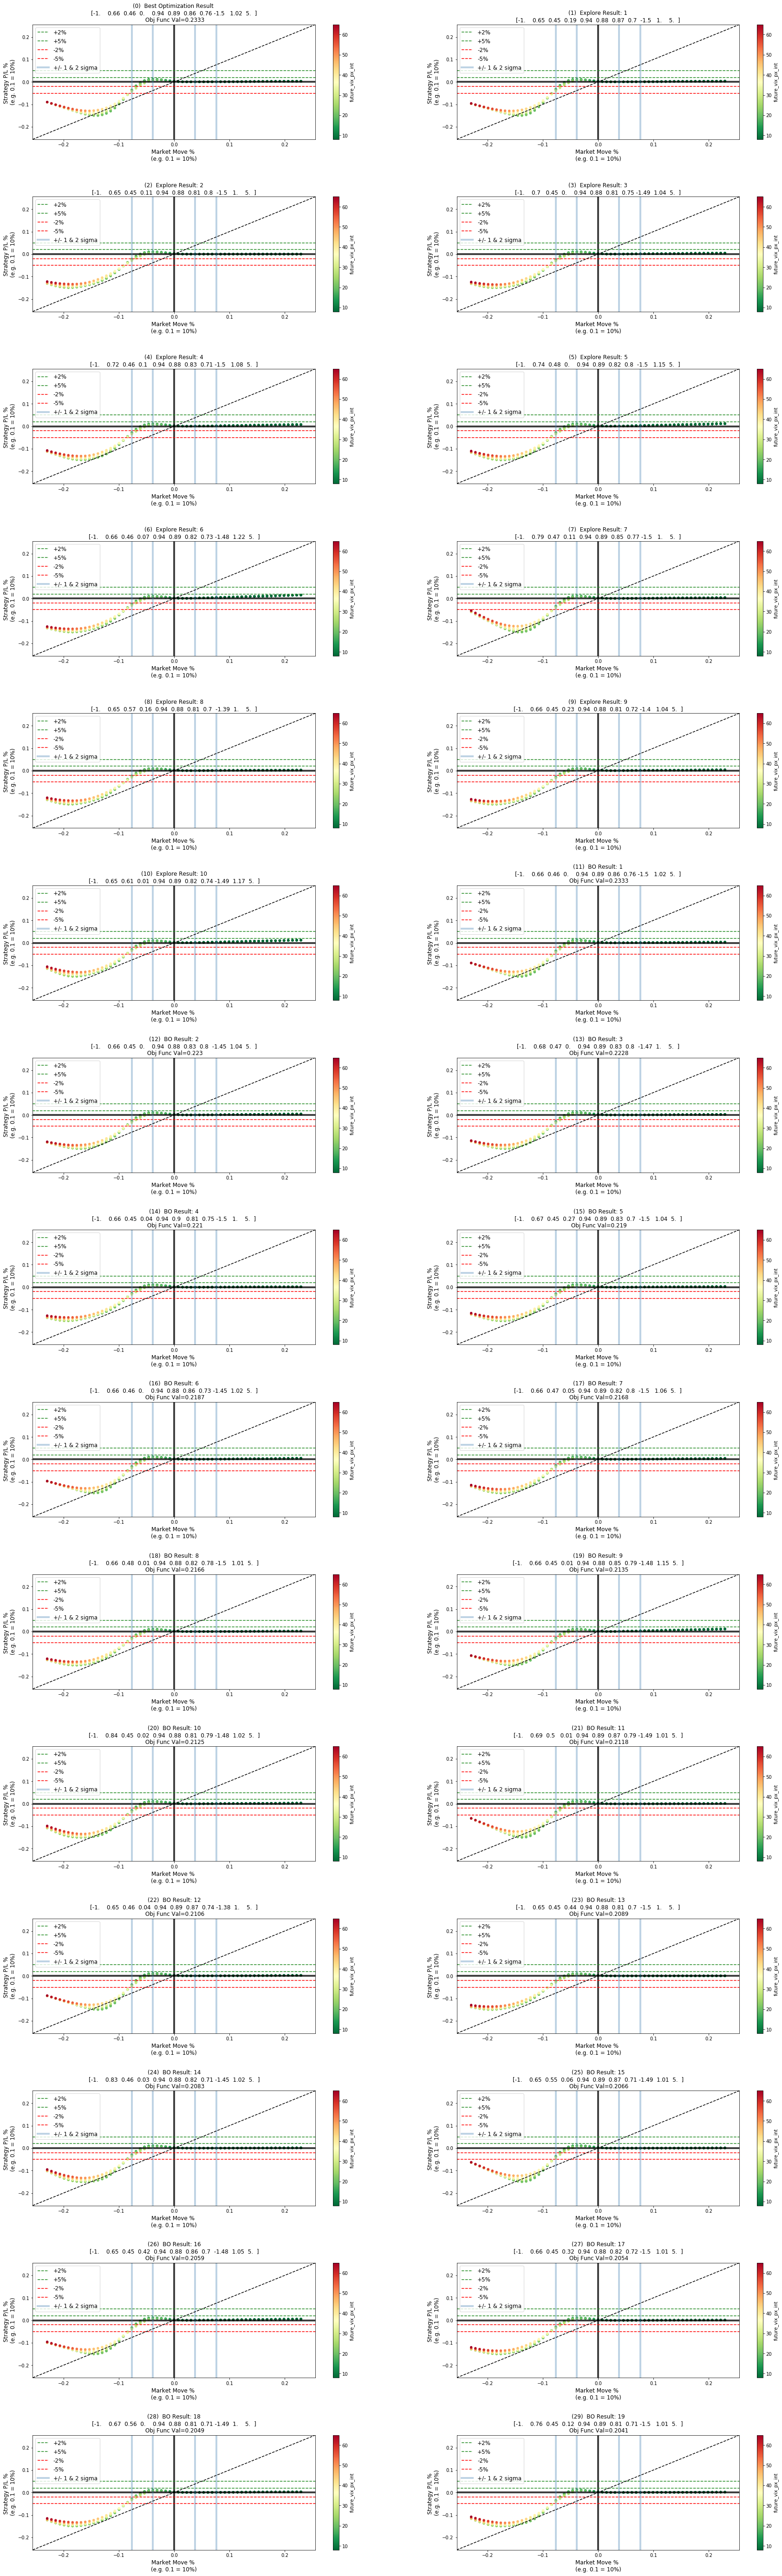

In [110]:
bo_results_viz_setup = {}
bo_results_viz_setup['explore_num'] = 10
bo_results_viz_setup['total_results'] = 30 

plot_bo_results(bo_strat=bo_strat_stage_2, strat_params_explore=strat_params_explore_stage_2, 
                max_explore_plots=bo_results_viz_setup['explore_num'], 
                subplots_total=bo_results_viz_setup['total_results'],
                figsize=(30,100), plot_hspace=0.50)

In [111]:
# Display the perf stats associated from ** STAGE 1 ** of the optimization

temp_opt_res, strat_params = run_bo_result(bo_strat)

perf_sig = perf_by_sigma_bands(temp_opt_res, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=True)
print('EV sum:', perf_sig['EV_rough'].sum())

perf_sig

Normalizing returns to a max drawdown of 15%

Max DD:  -0.2177552913871421
EV sum: -0.00031523455454239444


,EV_rough,ann_return,interval,interval_end,interval_start,prob
-0.5_-0.0_sigma,0.0106203,0.0554586,"(-0.01912717676946682, 0.0)",0,-0.0191272,0.1915
-1.0_-0.5_sigma,0.0135224,0.0901495,"(-0.03825435353893364, -0.01912717676946682)",-0.0191272,-0.0382544,0.15
-1.5_-1.0_sigma,0.00426255,0.0468412,"(-0.05738153030840046, -0.03825435353893364)",-0.0382544,-0.0573815,0.091
-2.0_-1.5_sigma,-0.00849954,-0.191001,"(-0.07650870707786728, -0.05738153030840046)",-0.0573815,-0.0765087,0.0445
-6.0_-2.0_sigma,-0.0243374,-1.08166,"(-0.23908970961833526, -0.07650870707786728)",-0.0765087,-0.23909,0.0225
0.0_0.5_sigma,0.00283584,0.0148085,"(0.0, 0.01912717676946682)",0.0191272,0,0.1915
0.5_1.0_sigma,0.000208109,0.00138739,"(0.01912717676946682, 0.03825435353893364)",0.0382544,0.0191272,0.15
1.0_1.5_sigma,0.000302462,0.00332376,"(0.03825435353893364, 0.05738153030840046)",0.0573815,0.0382544,0.091
1.5_2.0_sigma,0.000289336,0.00650192,"(0.05738153030840046, 0.07650870707786728)",0.0765087,0.0573815,0.0445
2.0_6.0_sigma,0.00048068,0.0213636,"(0.07650870707786728, 0.23908970961833526)",0.23909,0.0765087,0.0225


In [112]:
# Display the perf stats associated from ** STAGE 2 ** of the optimization

temp_opt_res, strat_params = run_bo_result(bo_strat_stage_2)

perf_sig = perf_by_sigma_bands(temp_opt_res, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=True)
print('EV sum:', perf_sig['EV_rough'].sum())

perf_sig

Normalizing returns to a max drawdown of 15%

Max DD:  -0.19710471838941224
EV sum: 0.0005265978763944487


,EV_rough,ann_return,interval,interval_end,interval_start,prob
-0.5_-0.0_sigma,0.0113951,0.0595045,"(-0.01912717676946682, 0.0)",0,-0.0191272,0.1915
-1.0_-0.5_sigma,0.0142926,0.0952841,"(-0.03825435353893364, -0.01912717676946682)",-0.0191272,-0.0382544,0.15
-1.5_-1.0_sigma,0.00418175,0.0459532,"(-0.05738153030840046, -0.03825435353893364)",-0.0382544,-0.0573815,0.091
-2.0_-1.5_sigma,-0.00942855,-0.211878,"(-0.07650870707786728, -0.05738153030840046)",-0.0573815,-0.0765087,0.0445
-6.0_-2.0_sigma,-0.0242352,-1.07712,"(-0.23908970961833526, -0.07650870707786728)",-0.0765087,-0.23909,0.0225
0.0_0.5_sigma,0.00312713,0.0163297,"(0.0, 0.01912717676946682)",0.0191272,0,0.1915
0.5_1.0_sigma,0.000244263,0.00162842,"(0.01912717676946682, 0.03825435353893364)",0.0382544,0.0191272,0.15
1.0_1.5_sigma,0.000276788,0.00304163,"(0.03825435353893364, 0.05738153030840046)",0.0573815,0.0382544,0.091
1.5_2.0_sigma,0.000256236,0.00575812,"(0.05738153030840046, 0.07650870707786728)",0.0765087,0.0573815,0.0445
2.0_6.0_sigma,0.000416432,0.0185081,"(0.07650870707786728, 0.23908970961833526)",0.23909,0.0765087,0.0225


In [163]:
def get_strategy_trades(strat_params, opt_results, exp_date, Rf, div, calendar_days_ahead_to_reprice, 
                        normalize_to_max_dd=0.10, 
                        portfolio_notional=100000, underlying_spot=999.99):
    
    max_dd_scale = abs( normalize_to_max_dd / opt_results.port_pct_pnl.min() )
    print('Max DD scaled to ', normalize_to_max_dd, ' scaling factor for exp_factor parameter = ', max_dd_scale, '\n')

    strat_params_dict = OrderedDict()

    strat_params_dict['short_put_1_notional'] = strat_params[0]
    strat_params_dict['long_put_1_notional'] = strat_params[1]
    strat_params_dict['long_put_2_notional'] = strat_params[2]
    strat_params_dict['long_put_3_notional'] = strat_params[3]

    strat_params_dict['short_put_1_mness'] = strat_params[4]
    strat_params_dict['long_put_1_mness'] =  strat_params[5]
    strat_params_dict['long_put_2_mness'] = strat_params[6]
    strat_params_dict['long_put_3_mness'] = strat_params[7]

    strat_params_dict['input_short_underlying_hedge_ratio'] = strat_params[8]
    strat_params_dict['input_long_call_1_hedge_factor'] = strat_params[9]
    strat_params_dict['input_exposure_factor'] = strat_params[10]
    #print('input_exposure_factor', strat_params_dict['input_exposure_factor'])
    strat_params_dict['input_exposure_factor'] = strat_params_dict['input_exposure_factor'] * max_dd_scale
    #print('input_exposure_factor', strat_params_dict['input_exposure_factor'])
        
    #print(strat_params_dict)
    
    portfolio_equity = portfolio_notional
    market_current = underlying_spot
    contracts_100pct_notional = portfolio_equity / (market_current * 100.)
    #print('contracts_100pct_notional', contracts_100pct_notional)

    exposure_factor = strat_params_dict['input_exposure_factor']
    short_underlying_hedge_ratio = strat_params_dict['input_short_underlying_hedge_ratio']
    call_1_hedge_factor = strat_params_dict['input_long_call_1_hedge_factor']

    num_contracts_short_put_1 = int( contracts_100pct_notional * exposure_factor )
    #print('num_contracts_short_put_1', num_contracts_short_put_1, exposure_factor)

    port = OrderedDict()

    temp_strike_theo = market_current * strat_params_dict['short_put_1_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( strat_params_dict['short_put_1_notional'] * num_contracts_short_put_1 )
    port['short_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * strat_params_dict['long_put_1_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    #temp_contract_notional = int( strat_params_dict['long_put_1_notional'] * num_contracts_short_put_1 )
    temp_contract_notional = int( np.round( strat_params_dict['long_put_1_notional'] * num_contracts_short_put_1, 0 ) )
    port['long_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * strat_params_dict['long_put_2_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    #temp_contract_notional = int( strat_params_dict['long_put_2_notional'] * num_contracts_short_put_1 )
    temp_contract_notional = int( np.round( strat_params_dict['long_put_2_notional'] * num_contracts_short_put_1, 0 ) )
    port['long_put_2'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * strat_params_dict['long_put_3_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    #temp_contract_notional = int( strat_params_dict['long_put_3_notional'] * num_contracts_short_put_1 ) 
    temp_contract_notional = int( np.round( strat_params_dict['long_put_3_notional'] * num_contracts_short_put_1, 0) )
    port['long_put_3'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')


    portfolio_greeks_info_puts_only = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    #print(portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts'], market_current)
    portfolio_greeks_info_puts_only_delta = portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta']

    #print('short_underlying_hedge_ratio = ',short_underlying_hedge_ratio)
    short_underlying_hedge_delta = short_underlying_hedge_ratio * portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts']
    port_equity_pos = market_current * short_underlying_hedge_delta

    #print("HEDGE: Port_equity_pos: ", port_equity_pos, "Hedge ratio:", short_underlying_hedge_delta, ', Shares to trade', int(port_equity_pos/market_current) )
    num_contracts_long_call_1 = int( ((port_equity_pos / market_current) / 100.) * (call_1_hedge_factor * -1.) ) + int(1)

    temp_strike_theo = market_current * 1.005
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = num_contracts_long_call_1
    port['long_call_1'] = Option(c_or_p='c', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_C, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    portfolio_greeks_info = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    ind_port_greeks = pd.DataFrame(portfolio_greeks_info['individual_port_greeks']).T

    portfolio_greeks_info['portfolio_level_greeks']['delta_options'] = portfolio_greeks_info['portfolio_level_greeks']['delta']
    portfolio_greeks_info['portfolio_level_greeks']['delta_options_puts_only'] = portfolio_greeks_info_puts_only_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta_underlying'] = short_underlying_hedge_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta'] = portfolio_greeks_info['portfolio_level_greeks']['delta_options'] + portfolio_greeks_info['portfolio_level_greeks']['delta_underlying']


    ##################################################################################

#     calendar_days_ahead_to_reprice = (pd.to_datetime(date_to_reprice) - pd.to_datetime(current_date)).days

    port_initial_prices = {}
    for option in port.keys():
        days_to_exp_init = ( port[option].exp_date - pd.to_datetime(current_date) ).days
        port_initial_prices[option] = bsm(c_or_p=port[option].c_or_p, S=market_current, K=port[option].strike, T=days_to_exp_init/365.25, r=Rf, d=div, v=port[option].initial_imp_vol)

             
    return { 'portfolio': port, 
             'greeks' : portfolio_greeks_info, 
             'initial_prices' : port_initial_prices,
             'strat_params' : strat_params_dict
           }



def gen_trades_from_bo_result(bo_strat, strat_params_explore, 
                              strat_to_get=0, 
                              num_explore_results=10, num_results_total=30):
    
    count = 0
    count_explore = 0
    count_best_bo = 0

    if strat_to_get >= num_results_total:
        print("ERROR: Please enter a valid index from the optimization subplots. Valid values are 0 to", str(num_results_total-1) )
        return None, None
        
    num_explore_combos = None
    if num_explore_results is None:
        num_explore_combos = len( strat_params_explore[ list(strat_params_explore.keys())[0] ] )
    else:
        num_explore_combos = num_explore_results

    top_opt_results_idx = get_top_opt_results(bo_strat, top_n=num_results_total)

    if strat_to_get == 0:
        temp_opt_res, strat_params = run_bo_result(bo_strat)
    else:
        if strat_to_get <= num_explore_combos:
            temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='init_trial', trial_num=strat_to_get - 1 )                

        else:
            temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='bo_trial', trial_num=top_opt_results_idx[ strat_to_get - num_explore_combos - 1] )

    # return temp_opt_res, strat_params
    
    return get_strategy_trades(strat_params=strat_params, opt_results=temp_opt_res, 
                               exp_date=exp_date, Rf=Rf, div=div, 
                               calendar_days_ahead_to_reprice=calendar_days_ahead_to_reprice, 
                               normalize_to_max_dd=max_dd_desired, portfolio_notional=portfolio_notional, 
                               underlying_spot=market_current)


In [164]:
#strat_to_get = 0
strat_to_get = 14

trade_info_dict = gen_trades_from_bo_result(bo_strat_stage_2, strat_params_explore_stage_2,
                                            strat_to_get=strat_to_get,
                                            num_explore_results=bo_results_viz_setup['explore_num'], 
                                            num_results_total=bo_results_viz_setup['total_results'])

trade_info_dict['strat_params']

Max DD scaled to  0.15  scaling factor for exp_factor parameter =  0.6144083888431494 



OrderedDict([('short_put_1_notional', -1.0),
             ('long_put_1_notional', 0.6638997648753542),
             ('long_put_2_notional', 0.45),
             ('long_put_3_notional', 0.044719708508381015),
             ('short_put_1_mness', 0.94),
             ('long_put_1_mness', 0.8964328956149841),
             ('long_put_2_mness', 0.81),
             ('long_put_3_mness', 0.7461387348959615),
             ('input_short_underlying_hedge_ratio', -1.5),
             ('input_long_call_1_hedge_factor', 1.0009793143206154),
             ('input_exposure_factor', 3.072041944215747)])

In [165]:
for i in trade_info_dict['portfolio']:
    p = trade_info_dict['portfolio']
    #print(p)
    #print(p[i])
    print( i, str(p[i].num_contracts), str(p[i].strike), str(p[i].initial_imp_vol), str(p[i].exp_date) )

print("\nUnderlying shares to trade: ", trade_info_dict['greeks']['portfolio_level_greeks']['delta_underlying'])


short_put_1 -11 258.0 0.1708 2018-07-20 00:00:00
long_put_1 7 246.0 0.2243 2018-07-20 00:00:00
long_put_2 5 222.0 0.3329 2018-07-20 00:00:00
long_put_3 0 205.0 0.409 2018-07-20 00:00:00
long_call_1 2 276.0 0.1094 2018-07-20 00:00:00

Underlying shares to trade:  -119.16327557223887


In [166]:
trade_info_dict['initial_prices']

{'long_call_1': 2.626520345387746,
 'long_put_1': 0.34593110864982357,
 'long_put_2': 0.125912044794398,
 'long_put_3': 0.06844401843589698,
 'short_put_1': 0.718010435177586}

In [167]:
trade_info_dict['greeks']['portfolio_level_greeks']

{'delta': 44.313341159984404,
 'delta_calls': 84.03443301739736,
 'delta_options': 163.47661673222328,
 'delta_options_puts_only': 79.44218371482592,
 'delta_puts': 79.44218371482592,
 'delta_underlying': -119.16327557223887,
 'gamma': -1.5553254515644586,
 'gamma_calls': 8.934848221955955,
 'gamma_puts': -10.490173673520413,
 'theta': 9.667142421812123,
 'theta_calls': -9.844593176171657,
 'theta_holding_period_30d_daily_avg': -0.3428105852362755,
 'theta_puts': 19.51173559798378,
 'vega': -32.6881513194555,
 'vega_calls': 62.538938142244845,
 'vega_puts': -95.22708946170033}

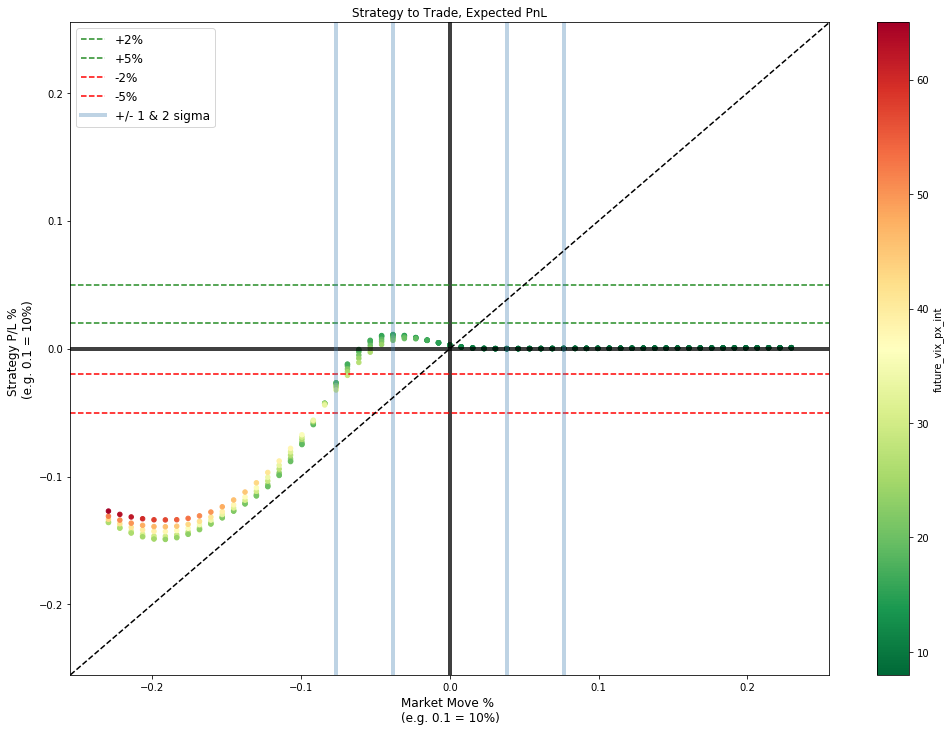

In [168]:
temp_opt_res = single_opt_run( opt_run_inputs=list( trade_info_dict['strat_params'].values() ) )

plot_opt_subplot(opt_result=temp_opt_res, ax_subplot=None, title_subplot='Strategy to Trade, Expected PnL', simple_plot=True, use_norm_returns=False)

In [169]:
perf_sig = perf_by_sigma_bands(temp_opt_res, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=False)

perf_sig

Max DD:  -0.1492184612184832


,EV_rough,ann_return,interval,interval_end,interval_start,prob
-0.5_-0.0_sigma,0.00996501,0.0520366,"(-0.01912717676946682, 0.0)",0,-0.0191272,0.1915
-1.0_-0.5_sigma,0.0126335,0.0842231,"(-0.03825435353893364, -0.01912717676946682)",-0.0191272,-0.0382544,0.15
-1.5_-1.0_sigma,0.00444217,0.048815,"(-0.05738153030840046, -0.03825435353893364)",-0.0382544,-0.0573815,0.091
-2.0_-1.5_sigma,-0.00677277,-0.152197,"(-0.07650870707786728, -0.05738153030840046)",-0.0573815,-0.0765087,0.0445
-6.0_-2.0_sigma,-0.0244849,-1.08822,"(-0.23908970961833526, -0.07650870707786728)",-0.0765087,-0.23909,0.0225
0.0_0.5_sigma,0.00278498,0.014543,"(0.0, 0.01912717676946682)",0.0191272,0,0.1915
0.5_1.0_sigma,0.000111648,0.000744321,"(0.01912717676946682, 0.03825435353893364)",0.0382544,0.0191272,0.15
1.0_1.5_sigma,2.92569e-05,0.000321504,"(0.03825435353893364, 0.05738153030840046)",0.0573815,0.0382544,0.091
1.5_2.0_sigma,4.3624e-05,0.000980314,"(0.05738153030840046, 0.07650870707786728)",0.0765087,0.0573815,0.0445
2.0_6.0_sigma,9.49886e-05,0.00422172,"(0.07650870707786728, 0.23908970961833526)",0.23909,0.0765087,0.0225


# WIP:  OPTIONAL:  Just for comparison purposes vs the Standard Test Case parameter set

Max DD:  -0.11669992559188051
EV sum: -0.007122492898223795
Max DD scaled to  0.1  scaling factor for exp_factor parameter =  0.8568985754945295 



,EV_rough,ann_return,interval,interval_end,interval_start,prob
-0.5_-0.0_sigma,0.0126673,0.0661477,"(-0.025429695328836596, 0.0)",0,-0.0254297,0.1915
-1.0_-0.5_sigma,0.00323955,0.021597,"(-0.05085939065767319, -0.025429695328836596)",-0.0254297,-0.0508594,0.15
-1.5_-1.0_sigma,-0.0161434,-0.1774,"(-0.07628908598650978, -0.05085939065767319)",-0.0508594,-0.0762891,0.091
-2.0_-1.5_sigma,-0.0204422,-0.459376,"(-0.10171878131534638, -0.07628908598650978)",-0.0762891,-0.101719,0.0445
-6.0_-2.0_sigma,0.00149247,0.066332,"(-0.31787119161045746, -0.10171878131534638)",-0.101719,-0.317871,0.0225
0.0_0.5_sigma,0.00528268,0.0275858,"(0.0, 0.025429695328836596)",0.0254297,0,0.1915
0.5_1.0_sigma,0.00161932,0.0107955,"(0.025429695328836596, 0.05085939065767319)",0.0508594,0.0254297,0.15
1.0_1.5_sigma,0.00179123,0.0196838,"(0.05085939065767319, 0.07628908598650978)",0.0762891,0.0508594,0.091
1.5_2.0_sigma,0.00140584,0.031592,"(0.07628908598650978, 0.10171878131534638)",0.101719,0.0762891,0.0445
2.0_6.0_sigma,0.00196473,0.0873215,"(0.10171878131534638, 0.31787119161045746)",0.317871,0.101719,0.0225


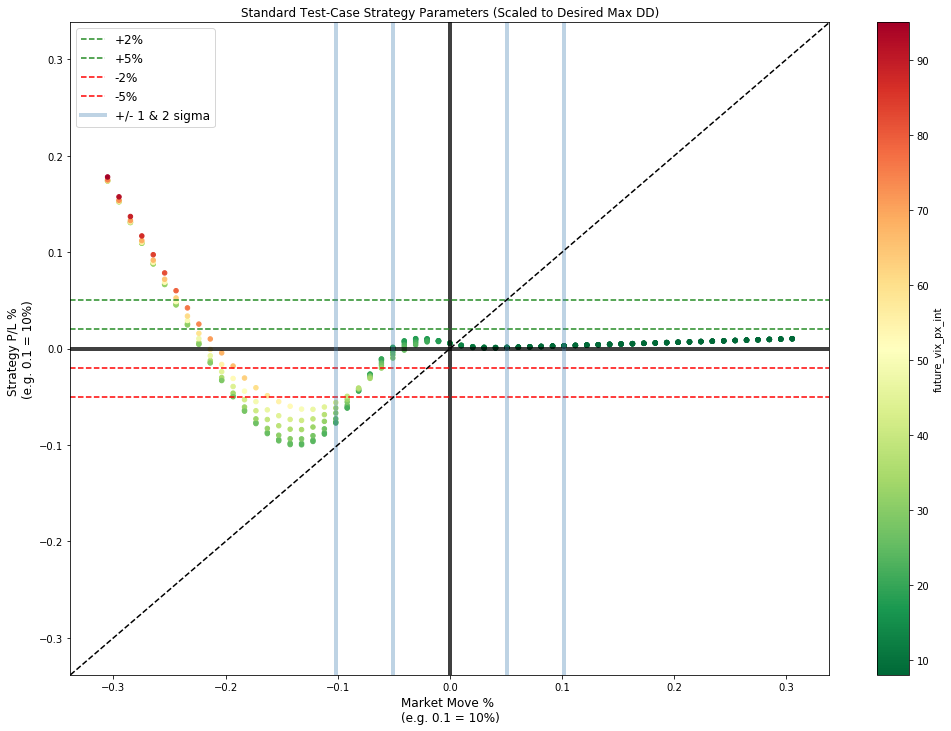

In [136]:
# Just for comparison purposes 
# STANDARD RUN:  (-1.0, 0.75, 0.50, 0.20, 0.95, 0.90, 0.85, 0.80, -1.5, 1.1, 4.0)

strat_params_to_run = OrderedDict()

strat_params_to_run['short_put_1_notional'] = -1.0
strat_params_to_run['long_put_1_notional'] = 0.75
strat_params_to_run['long_put_2_notional'] = 0.50
strat_params_to_run['long_put_3_notional'] = 0.20

strat_params_to_run['short_put_1_mness'] = 0.95
strat_params_to_run['long_put_1_mness'] =  0.9
strat_params_to_run['long_put_2_mness'] = 0.85
strat_params_to_run['long_put_3_mness'] = 0.80

strat_params_to_run['input_short_underlying_hedge_ratio'] = -1.5
strat_params_to_run['input_long_call_1_hedge_factor'] = 1.1
strat_params_to_run['input_exposure_factor'] = 4.0

temp_opt_res = single_opt_run( opt_run_inputs=list( strat_params_to_run.values() ) )

#plot_opt_subplot(opt_result=temp_opt_res, ax_subplot=None, title_subplot='Standard Test-Case Strategy Parameters', simple_plot=True)

########### Perf Stats ####
#max_dd_desired = 0.10

perf_sig = perf_by_sigma_bands(temp_opt_res, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice)
print('EV sum:', perf_sig['EV_rough'].sum())

max_dd_scale = abs( max_dd_desired / temp_opt_res.port_pct_pnl.min() )
print('Max DD scaled to ', max_dd_desired, ' scaling factor for exp_factor parameter = ', max_dd_scale, '\n')

# Scale the exposure factor to the amount needed to achieve the desired max_dd
strat_params_to_run['input_exposure_factor'] = strat_params_to_run['input_exposure_factor'] * max_dd_scale
temp_opt_res = single_opt_run( opt_run_inputs=list( strat_params_to_run.values() ) )

plot_opt_subplot(opt_result=temp_opt_res, ax_subplot=None, title_subplot='Standard Test-Case Strategy Parameters (Scaled to Desired Max DD)', 
                 simple_plot=True, use_norm_returns=False)

perf_sig

In [ ]:
# MANUAL APPROACH: ENTER the values that you want to generate trades for

strat_params_to_run = OrderedDict()

# STANDARD RUN:  (-1.0, 0.75, 0.50, 0.20, 0.95, 0.90, 0.85, 0.80, -1.5, 1.1, 4.0)

strat_params_to_run['short_put_1_notional'] = -1.0
strat_params_to_run['long_put_1_notional'] = 0.75
strat_params_to_run['long_put_2_notional'] = 0.50
strat_params_to_run['long_put_3_notional'] = 0.20

strat_params_to_run['short_put_1_mness'] = 0.95
strat_params_to_run['long_put_1_mness'] =  0.9
strat_params_to_run['long_put_2_mness'] = 0.85
strat_params_to_run['long_put_3_mness'] = 0.80

strat_params_to_run['input_short_underlying_hedge_ratio'] = -1.5
strat_params_to_run['input_long_call_1_hedge_factor'] = 1.1
strat_params_to_run['input_exposure_factor'] = 4.0

temp_opt_res = single_opt_run( opt_run_inputs=list( strat_params_to_run.values() ) )
